### Installing Dependencies

In [ ]:
!pip install -q flwr[simulation] torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 14.8

### Mount Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Set-Up

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import warnings
warnings.filterwarnings("ignore")
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import flwr as fl
from flwr.common import Metrics
import torchvision.models as models
import torch.optim as optim

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")

Training on cuda using PyTorch 2.0.0+cu118 and Flower 1.3.0


## Load Dataset

#### Define Torch Dataloader

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.ImageFolder(root='drive/MyDrive/archive/gaussian_filtered_images/gaussian_filtered_images', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

#### Display data

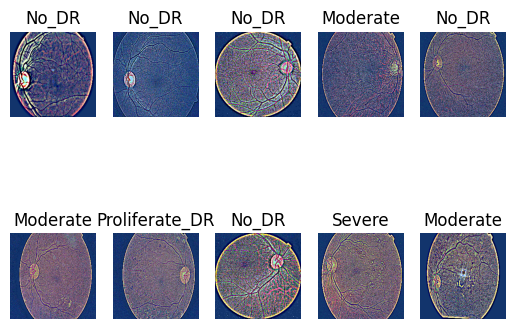

In [ ]:
def index_to_class_name(index, dataset):
    return dataset.classes[index]

len_images = 10
images, labels = next(iter(dataloader))
sample_indices = np.random.choice(len(images), len_images, replace=False)
sample_images = images[sample_indices]
sample_labels = labels[sample_indices]

for i, image in enumerate(sample_images):
    class_name = index_to_class_name(sample_labels[i], dataset)
    plt.subplot(2, 5, i+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(class_name)
    plt.axis('off')

plt.show() 

#### Data Splitter Utility

In [ ]:
BATCH_SIZE = 8

In [ ]:
def data_splitter(nodr=[0.2,0.2,0.2,0.2,0.2],mild=[0.2,0.2,0.2,0.2,0.2],moderate=[0.2,0.2,0.2,0.2,0.2],severe=[0.2,0.2,0.2,0.2,0.2],proliferate=[0.2,0.2,0.2,0.2,0.2],num_clients=5):
    datasets_individual=[]
    train_datasets_individual = []
    test_datasets_individual = []
    for i in range(5):
        classes = torch.tensor([i])
        # get indices that correspond to one of the selected classes
        indices = (torch.tensor(dataset.targets)[..., None] == classes).any(-1).nonzero(as_tuple=True)[0]
        data = torch.utils.data.Subset(dataset, indices) # subset the dataset
        datasets_individual.append(data)
    
    for i in range(5):
        train_temp, test_temp = torch.utils.data.random_split(datasets_individual[i], [int(0.8 * len(datasets_individual[i].indices)), len(datasets_individual[i].indices) - int(0.8 * len(datasets_individual[i].indices))])
        train_datasets_individual.append(train_temp)
        test_datasets_individual.append(test_temp)
    
    
    testset = torch.utils.data.ConcatDataset([test_datasets_individual[0],test_datasets_individual[1],test_datasets_individual[2],test_datasets_individual[3],test_datasets_individual[4]])

    train_datasets=[]
    for i in range(5):
        if dataset.classes[i]=="Mild":
            lengths=[a*len(train_datasets_individual[i]) for a in mild]
        elif dataset.classes[i]=="Moderate":
            lengths=[a*len(train_datasets_individual[i]) for a in moderate]
        elif dataset.classes[i]=="No_DR":
            lengths=[a*len(train_datasets_individual[i]) for a in nodr]
        elif dataset.classes[i]=="Proliferate_DR":
            lengths=[a*len(train_datasets_individual[i]) for a in proliferate]
        elif dataset.classes[i]=="Severe":
            lengths=[a*len(train_datasets_individual[i]) for a in severe]
        lengths=[int(l) for l in lengths]
        lengths[4]=len(train_datasets_individual[i])-sum(lengths[0:4])
        train_data = random_split(train_datasets_individual[i],lengths,torch.Generator().manual_seed(42))
        train_datasets.append(train_data)

    client_datasets=[]
    for i in range(num_clients):
        client_datasets.append(torch.utils.data.ConcatDataset([train_datasets[0][i],train_datasets[1][i],train_datasets[2][i],train_datasets[3][i],train_datasets[4][i]]))

    trainloaders = []
    valloaders = []
    test_len = len(testset) // num_clients
    test_lens = [test_len]*num_clients
    test_lens[-1] = len(testset) - test_len*(num_clients-1)
    valset = random_split(testset, test_lens, torch.Generator().manual_seed(42))

    for ds in client_datasets:
      trainloaders.append(DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True))

    for ds in valset:
      valloaders.append(DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True))

    return trainloaders, valloaders


In [ ]:
def split_dataset_to_equal_length_but_unequal_classes(num_clients=5):
    partition_size = len(dataset) // num_clients
    data_points_per_client_lengths = [partition_size]*num_clients
    data_points_per_client_lengths[-1] = len(dataset) - partition_size*(num_clients-1)

    dataset_for_clients = random_split(dataset, data_points_per_client_lengths, torch.Generator().manual_seed(42))

    trainloaders = []
    valloaders = []
    for ds in dataset_for_clients:
        len_val = len(ds) // 5  # 20 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=True))
    
    return trainloaders, valloaders

In [ ]:
def split_dataset_for_global_training():
    trainset, testset= torch.utils.data.random_split(dataset, [2930, 732])
    trainSetLoader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    testSetLoader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)
    return trainSetLoader, testSetLoader

## Model Definition

In [ ]:
# class Net(nn.Module):
#     def __init__(self, num_classes=5):
#         super(Net, self).__init__()
#         self.num_classes = num_classes
#         self.inception = models.googlenet(pretrained=True)
        
#         for param in self.inception.parameters():
#             param.requires_grad = False
            
#         self.inception.fc = nn.Linear(self.inception.fc.in_features, num_classes)

#     def forward(self, x):
#         x = self.inception(x)
#         return F.log_softmax(x, dim=1)

In [ ]:
# from torchsummary import summary
# vgg = models.vgg16(pretrained=True)
# print(vgg)

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes=5):
        super(Net, self).__init__()
        self.num_classes = num_classes
        self.alexnet = models.alexnet(pretrained=True)
        
        for param in self.alexnet.parameters():
            param.requires_grad = False
            
        self.alexnet.classifier[6] = nn.Linear(self.alexnet.classifier[6].in_features, num_classes)

    def forward(self, x):
        x = self.alexnet(x)
        return F.log_softmax(x, dim=1)

In [ ]:
# class Net(nn.Module):
#     def __init__(self) -> None:
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 8, 4)
#         # self.bn1 = nn.BatchNorm2d(8)
#         self.conv2 = nn.Conv2d(8, 16, 4)
#         # self.bn2 = nn.BatchNorm2d(16)
#         self.conv3 = nn.Conv2d(16,32,4)
#         # self.bn3 = nn.BatchNorm2d(32)
#         self.pool = nn.MaxPool2d(2,2)
#         self.fc1 = nn.Linear(32*53*53,128)
#         self.fc2 = nn.Linear(128,5)
#         self.relu = nn.ReLU()
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = self.relu(self.conv1(x))
#         x = self.pool(self.relu(self.conv2(x)))
#         x = self.pool(self.relu(self.conv3(x)))
#         x = x.view(-1, 32 * 53 * 53 )
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         return F.log_softmax(x, dim=1)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(Net())

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 202MB/s]


20485

In [ ]:
from tqdm import tqdm
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    print(optimizer)
    net.train()
    for epoch in range(epochs):
      correct, total, epoch_loss = 0, 0, 0.0
      for images, labels in tqdm(trainloader):
          images, labels = images.to(DEVICE), labels.to(DEVICE)
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          # Metrics
          epoch_loss += loss
          total += labels.size(0)
          correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
      epoch_loss /= len(trainloader.dataset)
      epoch_acc = correct / total
      if verbose:
          print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in tqdm(testloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
def print_data_split(trainloaders, valloaders):
    for i in range(len(trainloaders)):
        print("Client " + str(i+1) + " - Train Size: " + str(len(trainloaders[i].dataset)))
        print("Client " + str(i+1) + " - Test Size: " + str(len(valloaders[i].dataset)))

## Global Training (Without Federated Learning)

In [ ]:
train_global,val_global = split_dataset_for_global_training()

In [ ]:
net = Net().to(DEVICE)
train(net, train_global, 5)
loss_global, accuracy_global = test(net, val_global)
print(f" validation loss {loss_global}, accuracy {accuracy_global}")

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


100%|██████████| 92/92 [00:04<00:00, 22.71it/s]

 validation loss 0.10077783277594164, accuracy 0.7581967213114754


## Federated Learning

#### Utility Functions

In [ ]:
def get_parameters(net):
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = {k: torch.Tensor(v) for k, v in params_dict}
    net.load_state_dict(state_dict, strict=True)

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

In [ ]:
def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    local_accuracies = [m["accuracy"] for num_examples, m in metrics]
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"global accuracy": sum(accuracies) / sum(examples), "local accuracies":local_accuracies}

# Can return individual if needed

In [ ]:
def run_fedAvg(num_of_rounds=5):
    # Create FedAvg strategy
    strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    )

    # Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
    client_resources = None
    if DEVICE.type == "cuda":
        client_resources = {"num_gpus": 1}

    # Start simulation
    fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=num_of_rounds),
        strategy=strategy,
        client_resources=client_resources,
    )

#### Starting federated learning with Number of Clients as 5 with strategy FedAvg

In [ ]:
NUM_CLIENTS = 5

#### Case 1: Equal Length Data & Unequal Classes

In [ ]:
trainloaders, valloaders = split_dataset_to_equal_length_but_unequal_classes(NUM_CLIENTS)

In [ ]:
print_data_split(trainloaders, valloaders)

Client 1 - Train Size: 586
Client 1 - Test Size: 146
Client 2 - Train Size: 586
Client 2 - Test Size: 146
Client 3 - Train Size: 586
Client 3 - Test Size: 146
Client 4 - Train Size: 586
Client 4 - Test Size: 146
Client 5 - Train Size: 588
Client 5 - Test Size: 146


In [ ]:
run_fedAvg()

INFO flwr 2023-04-12 23:12:16,675 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-12 23:12:21,297	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-12 23:12:22,741 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 3999812812.0, 'memory': 7999625627.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 3999812812.0, 'memory': 7999625627.0, 'GPU': 1.0}
INFO flwr 2023-04-12 23:12:22,752 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-12 23:12:22,758 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


(launch_and_fit pid=46056) Adam (
(launch_and_fit pid=46056) Parameter Group 0
(launch_and_fit pid=46056)     amsgrad: False
(launch_and_fit pid=46056)     betas: (0.9, 0.999)
(launch_and_fit pid=46056)     capturable: False
(launch_and_fit pid=46056)     differentiable: False
(launch_and_fit pid=46056)     eps: 1e-08
(launch_and_fit pid=46056)     foreach: None
(launch_and_fit pid=46056)     fused: None
(launch_and_fit pid=46056)     lr: 0.001
(launch_and_fit pid=46056)     maximize: False
(launch_and_fit pid=46056)     weight_decay: 0
(launch_and_fit pid=46056) )


100%|██████████| 74/74 [00:03<00:00, 24.38it/s]
(launch_and_fit pid=46153) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=46153)   warnings.warn(
(launch_and_fit pid=46153) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=46153)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=46153) Adam (
(launch_and_fit pid=46153) Parameter Group 0
(launch_and_fit pid=46153)     amsgrad: False
(launch_and_fit pid=46153)     betas: (0.9, 0.999)
(launch_and_fit pid=46153)     capturable: False
(launch_and_fit pid=46153)     differentiable: False
(launch_and_fit pid=46153)     eps: 1e-08
(launch_and_fit pid=46153)     foreach: None
(launch_and_fit pid=46153)     fused: None
(launch_and_fit pid=46153)     lr: 0.001
(launch_and_fit pid=46153)     maximize: False
(launch_and_fit pid=46153)     weight_decay: 0
(launch_and_fit pid=46153) )


100%|██████████| 74/74 [00:03<00:00, 20.16it/s]
(launch_and_fit pid=46251) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=46251)   warnings.warn(
(launch_and_fit pid=46251) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=46251)   warnings.warn(msg)


(launch_and_fit pid=46251) Adam (
(launch_and_fit pid=46251) Parameter Group 0
(launch_and_fit pid=46251)     amsgrad: False
(launch_and_fit pid=46251)     betas: (0.9, 0.999)
(launch_and_fit pid=46251)     capturable: False
(launch_and_fit pid=46251)     differentiable: False
(launch_and_fit pid=46251)     eps: 1e-08
(launch_and_fit pid=46251)     foreach: None
(launch_and_fit pid=46251)     fused: None
(launch_and_fit pid=46251)     lr: 0.001
(launch_and_fit pid=46251)     maximize: False
(launch_and_fit pid=46251)     weight_decay: 0
(launch_and_fit pid=46251) )


100%|██████████| 74/74 [00:03<00:00, 24.62it/s]
(launch_and_fit pid=46343) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=46343)   warnings.warn(
(launch_and_fit pid=46343) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=46343)   warnings.warn(msg)


(launch_and_fit pid=46343) Adam (
(launch_and_fit pid=46343) Parameter Group 0
(launch_and_fit pid=46343)     amsgrad: False
(launch_and_fit pid=46343)     betas: (0.9, 0.999)
(launch_and_fit pid=46343)     capturable: False
(launch_and_fit pid=46343)     differentiable: False
(launch_and_fit pid=46343)     eps: 1e-08
(launch_and_fit pid=46343)     foreach: None
(launch_and_fit pid=46343)     fused: None
(launch_and_fit pid=46343)     lr: 0.001
(launch_and_fit pid=46343)     maximize: False
(launch_and_fit pid=46343)     weight_decay: 0
(launch_and_fit pid=46343) )


100%|██████████| 74/74 [00:03<00:00, 19.93it/s]
(launch_and_fit pid=46442) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=46442)   warnings.warn(
(launch_and_fit pid=46442) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=46442)   warnings.warn(msg)


(launch_and_fit pid=46442) Adam (
(launch_and_fit pid=46442) Parameter Group 0
(launch_and_fit pid=46442)     amsgrad: False
(launch_and_fit pid=46442)     betas: (0.9, 0.999)
(launch_and_fit pid=46442)     capturable: False
(launch_and_fit pid=46442)     differentiable: False
(launch_and_fit pid=46442)     eps: 1e-08
(launch_and_fit pid=46442)     foreach: None
(launch_and_fit pid=46442)     fused: None
(launch_and_fit pid=46442)     lr: 0.001
(launch_and_fit pid=46442)     maximize: False
(launch_and_fit pid=46442)     weight_decay: 0
(launch_and_fit pid=46442) )


100%|██████████| 74/74 [00:03<00:00, 23.67it/s]
DEBUG flwr 2023-04-12 23:13:09,369 | server.py:229 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-12 23:13:11,153 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-12 23:13:11,179 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=46558) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=46558)   warnings.warn(
(launch_and_evaluate pid=46558) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The cu

(launch_and_fit pid=46905) Adam (
(launch_and_fit pid=46905) Parameter Group 0
(launch_and_fit pid=46905)     amsgrad: False
(launch_and_fit pid=46905)     betas: (0.9, 0.999)
(launch_and_fit pid=46905)     capturable: False
(launch_and_fit pid=46905)     differentiable: False
(launch_and_fit pid=46905)     eps: 1e-08
(launch_and_fit pid=46905)     foreach: None
(launch_and_fit pid=46905)     fused: None
(launch_and_fit pid=46905)     lr: 0.001
(launch_and_fit pid=46905)     maximize: False
(launch_and_fit pid=46905)     weight_decay: 0
(launch_and_fit pid=46905) )


100%|██████████| 74/74 [00:03<00:00, 23.85it/s]
(launch_and_fit pid=47003) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=47003)   warnings.warn(
(launch_and_fit pid=47003) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=47003)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=47003) Adam (
(launch_and_fit pid=47003) Parameter Group 0
(launch_and_fit pid=47003)     amsgrad: False
(launch_and_fit pid=47003)     betas: (0.9, 0.999)
(launch_and_fit pid=47003)     capturable: False
(launch_and_fit pid=47003)     differentiable: False
(launch_and_fit pid=47003)     eps: 1e-08
(launch_and_fit pid=47003)     foreach: None
(launch_and_fit pid=47003)     fused: None
(launch_and_fit pid=47003)     lr: 0.001
(launch_and_fit pid=47003)     maximize: False
(launch_and_fit pid=47003)     weight_decay: 0
(launch_and_fit pid=47003) )


100%|██████████| 74/74 [00:03<00:00, 23.98it/s]
(launch_and_fit pid=47109) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=47109)   warnings.warn(
(launch_and_fit pid=47109) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=47109)   warnings.warn(msg)


(launch_and_fit pid=47109) Adam (
(launch_and_fit pid=47109) Parameter Group 0
(launch_and_fit pid=47109)     amsgrad: False
(launch_and_fit pid=47109)     betas: (0.9, 0.999)
(launch_and_fit pid=47109)     capturable: False
(launch_and_fit pid=47109)     differentiable: False
(launch_and_fit pid=47109)     eps: 1e-08
(launch_and_fit pid=47109)     foreach: None
(launch_and_fit pid=47109)     fused: None
(launch_and_fit pid=47109)     lr: 0.001
(launch_and_fit pid=47109)     maximize: False
(launch_and_fit pid=47109)     weight_decay: 0
(launch_and_fit pid=47109) )


100%|██████████| 74/74 [00:03<00:00, 22.53it/s]
(launch_and_fit pid=47203) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=47203)   warnings.warn(
(launch_and_fit pid=47203) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=47203)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=47203) Adam (
(launch_and_fit pid=47203) Parameter Group 0
(launch_and_fit pid=47203)     amsgrad: False
(launch_and_fit pid=47203)     betas: (0.9, 0.999)
(launch_and_fit pid=47203)     capturable: False
(launch_and_fit pid=47203)     differentiable: False
(launch_and_fit pid=47203)     eps: 1e-08
(launch_and_fit pid=47203)     foreach: None
(launch_and_fit pid=47203)     fused: None
(launch_and_fit pid=47203)     lr: 0.001
(launch_and_fit pid=47203)     maximize: False
(launch_and_fit pid=47203)     weight_decay: 0
(launch_and_fit pid=47203) )


100%|██████████| 74/74 [00:03<00:00, 24.10it/s]
(launch_and_fit pid=47303) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=47303)   warnings.warn(
(launch_and_fit pid=47303) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=47303)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=47303) Adam (
(launch_and_fit pid=47303) Parameter Group 0
(launch_and_fit pid=47303)     amsgrad: False
(launch_and_fit pid=47303)     betas: (0.9, 0.999)
(launch_and_fit pid=47303)     capturable: False
(launch_and_fit pid=47303)     differentiable: False
(launch_and_fit pid=47303)     eps: 1e-08
(launch_and_fit pid=47303)     foreach: None
(launch_and_fit pid=47303)     fused: None
(launch_and_fit pid=47303)     lr: 0.001
(launch_and_fit pid=47303)     maximize: False
(launch_and_fit pid=47303)     weight_decay: 0
(launch_and_fit pid=47303) )


100%|██████████| 74/74 [00:03<00:00, 21.95it/s]
DEBUG flwr 2023-04-12 23:14:21,382 | server.py:229 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures
DEBUG flwr 2023-04-12 23:14:23,813 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=47421) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=47421)   warnings.warn(
(launch_and_evaluate pid=47421) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also 

(scheduler +13m25s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


100%|██████████| 19/19 [00:01<00:00, 14.09it/s]
(launch_and_evaluate pid=47860) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=47860)   warnings.warn(
(launch_and_evaluate pid=47860) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=47860)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 17.03it/s]
DEBUG flwr 2023-04-12 23:15:02,821 | server.py:179 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 

(launch_and_fit pid=47941) Adam (
(launch_and_fit pid=47941) Parameter Group 0
(launch_and_fit pid=47941)     amsgrad: False
(launch_and_fit pid=47941)     betas: (0.9, 0.999)
(launch_and_fit pid=47941)     capturable: False
(launch_and_fit pid=47941)     differentiable: False
(launch_and_fit pid=47941)     eps: 1e-08
(launch_and_fit pid=47941)     foreach: None
(launch_and_fit pid=47941)     fused: None
(launch_and_fit pid=47941)     lr: 0.001
(launch_and_fit pid=47941)     maximize: False
(launch_and_fit pid=47941)     weight_decay: 0
(launch_and_fit pid=47941) )


100%|██████████| 74/74 [00:04<00:00, 16.04it/s]
(launch_and_fit pid=48063) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=48063)   warnings.warn(
(launch_and_fit pid=48063) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=48063)   warnings.warn(msg)


(launch_and_fit pid=48063) Adam (
(launch_and_fit pid=48063) Parameter Group 0
(launch_and_fit pid=48063)     amsgrad: False
(launch_and_fit pid=48063)     betas: (0.9, 0.999)
(launch_and_fit pid=48063)     capturable: False
(launch_and_fit pid=48063)     differentiable: False
(launch_and_fit pid=48063)     eps: 1e-08
(launch_and_fit pid=48063)     foreach: None
(launch_and_fit pid=48063)     fused: None
(launch_and_fit pid=48063)     lr: 0.001
(launch_and_fit pid=48063)     maximize: False
(launch_and_fit pid=48063)     weight_decay: 0
(launch_and_fit pid=48063) )


100%|██████████| 74/74 [00:03<00:00, 20.98it/s]
(launch_and_fit pid=48173) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=48173)   warnings.warn(
(launch_and_fit pid=48173) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=48173)   warnings.warn(msg)


(launch_and_fit pid=48173) Adam (
(launch_and_fit pid=48173) Parameter Group 0
(launch_and_fit pid=48173)     amsgrad: False
(launch_and_fit pid=48173)     betas: (0.9, 0.999)
(launch_and_fit pid=48173)     capturable: False
(launch_and_fit pid=48173)     differentiable: False
(launch_and_fit pid=48173)     eps: 1e-08
(launch_and_fit pid=48173)     foreach: None
(launch_and_fit pid=48173)     fused: None
(launch_and_fit pid=48173)     lr: 0.001
(launch_and_fit pid=48173)     maximize: False
(launch_and_fit pid=48173)     weight_decay: 0
(launch_and_fit pid=48173) )


100%|██████████| 74/74 [00:05<00:00, 13.70it/s]
(launch_and_fit pid=48294) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=48294)   warnings.warn(
(launch_and_fit pid=48294) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=48294)   warnings.warn(msg)


(launch_and_fit pid=48294) Adam (
(launch_and_fit pid=48294) Parameter Group 0
(launch_and_fit pid=48294)     amsgrad: False
(launch_and_fit pid=48294)     betas: (0.9, 0.999)
(launch_and_fit pid=48294)     capturable: False
(launch_and_fit pid=48294)     differentiable: False
(launch_and_fit pid=48294)     eps: 1e-08
(launch_and_fit pid=48294)     foreach: None
(launch_and_fit pid=48294)     fused: None
(launch_and_fit pid=48294)     lr: 0.001
(launch_and_fit pid=48294)     maximize: False
(launch_and_fit pid=48294)     weight_decay: 0
(launch_and_fit pid=48294) )


100%|██████████| 74/74 [00:03<00:00, 19.58it/s]
(launch_and_fit pid=48396) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=48396)   warnings.warn(
(launch_and_fit pid=48396) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=48396)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=48396) Adam (
(launch_and_fit pid=48396) Parameter Group 0
(launch_and_fit pid=48396)     amsgrad: False
(launch_and_fit pid=48396)     betas: (0.9, 0.999)
(launch_and_fit pid=48396)     capturable: False
(launch_and_fit pid=48396)     differentiable: False
(launch_and_fit pid=48396)     eps: 1e-08
(launch_and_fit pid=48396)     foreach: None
(launch_and_fit pid=48396)     fused: None
(launch_and_fit pid=48396)     lr: 0.001
(launch_and_fit pid=48396)     maximize: False
(launch_and_fit pid=48396)     weight_decay: 0
(launch_and_fit pid=48396) )


100%|██████████| 74/74 [00:04<00:00, 14.81it/s]
DEBUG flwr 2023-04-12 23:15:53,742 | server.py:229 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures
DEBUG flwr 2023-04-12 23:15:57,548 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=48542) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=48542)   warnings.warn(
(launch_and_evaluate pid=48542) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also 

(launch_and_fit pid=48921) Adam (
(launch_and_fit pid=48921) Parameter Group 0
(launch_and_fit pid=48921)     amsgrad: False
(launch_and_fit pid=48921)     betas: (0.9, 0.999)
(launch_and_fit pid=48921)     capturable: False
(launch_and_fit pid=48921)     differentiable: False
(launch_and_fit pid=48921)     eps: 1e-08
(launch_and_fit pid=48921)     foreach: None
(launch_and_fit pid=48921)     fused: None
(launch_and_fit pid=48921)     lr: 0.001
(launch_and_fit pid=48921)     maximize: False
(launch_and_fit pid=48921)     weight_decay: 0
(launch_and_fit pid=48921) )


100%|██████████| 74/74 [00:04<00:00, 18.45it/s]
(launch_and_fit pid=49024) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=49024)   warnings.warn(
(launch_and_fit pid=49024) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=49024)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=49024) Adam (
(launch_and_fit pid=49024) Parameter Group 0
(launch_and_fit pid=49024)     amsgrad: False
(launch_and_fit pid=49024)     betas: (0.9, 0.999)
(launch_and_fit pid=49024)     capturable: False
(launch_and_fit pid=49024)     differentiable: False
(launch_and_fit pid=49024)     eps: 1e-08
(launch_and_fit pid=49024)     foreach: None
(launch_and_fit pid=49024)     fused: None
(launch_and_fit pid=49024)     lr: 0.001
(launch_and_fit pid=49024)     maximize: False
(launch_and_fit pid=49024)     weight_decay: 0
(launch_and_fit pid=49024) )


100%|██████████| 74/74 [00:04<00:00, 18.36it/s]
(launch_and_fit pid=49134) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=49134)   warnings.warn(
(launch_and_fit pid=49134) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=49134)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=49134) Adam (
(launch_and_fit pid=49134) Parameter Group 0
(launch_and_fit pid=49134)     amsgrad: False
(launch_and_fit pid=49134)     betas: (0.9, 0.999)
(launch_and_fit pid=49134)     capturable: False
(launch_and_fit pid=49134)     differentiable: False
(launch_and_fit pid=49134)     eps: 1e-08
(launch_and_fit pid=49134)     foreach: None
(launch_and_fit pid=49134)     fused: None
(launch_and_fit pid=49134)     lr: 0.001
(launch_and_fit pid=49134)     maximize: False
(launch_and_fit pid=49134)     weight_decay: 0
(launch_and_fit pid=49134) )


100%|██████████| 74/74 [00:04<00:00, 17.30it/s]
(launch_and_fit pid=49248) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=49248)   warnings.warn(
(launch_and_fit pid=49248) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=49248)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=49248) Adam (
(launch_and_fit pid=49248) Parameter Group 0
(launch_and_fit pid=49248)     amsgrad: False
(launch_and_fit pid=49248)     betas: (0.9, 0.999)
(launch_and_fit pid=49248)     capturable: False
(launch_and_fit pid=49248)     differentiable: False
(launch_and_fit pid=49248)     eps: 1e-08
(launch_and_fit pid=49248)     foreach: None
(launch_and_fit pid=49248)     fused: None
(launch_and_fit pid=49248)     lr: 0.001
(launch_and_fit pid=49248)     maximize: False
(launch_and_fit pid=49248)     weight_decay: 0
(launch_and_fit pid=49248) )


100%|██████████| 74/74 [00:03<00:00, 20.81it/s]
(launch_and_fit pid=49353) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=49353)   warnings.warn(
(launch_and_fit pid=49353) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=49353)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=49353) Adam (
(launch_and_fit pid=49353) Parameter Group 0
(launch_and_fit pid=49353)     amsgrad: False
(launch_and_fit pid=49353)     betas: (0.9, 0.999)
(launch_and_fit pid=49353)     capturable: False
(launch_and_fit pid=49353)     differentiable: False
(launch_and_fit pid=49353)     eps: 1e-08
(launch_and_fit pid=49353)     foreach: None
(launch_and_fit pid=49353)     fused: None
(launch_and_fit pid=49353)     lr: 0.001
(launch_and_fit pid=49353)     maximize: False
(launch_and_fit pid=49353)     weight_decay: 0
(launch_and_fit pid=49353) )


100%|██████████| 74/74 [00:04<00:00, 16.67it/s]
DEBUG flwr 2023-04-12 23:17:18,484 | server.py:229 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures
DEBUG flwr 2023-04-12 23:17:23,074 | server.py:165 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)
(raylet) Spilled 4143 MiB, 46 objects, write throughput 199 MiB/s.
(launch_and_evaluate pid=49497) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=49497)   warnings.warn(
(launch_and_evaluate pid=49497) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalen

(launch_and_fit pid=49919) Adam (
(launch_and_fit pid=49919) Parameter Group 0
(launch_and_fit pid=49919)     amsgrad: False
(launch_and_fit pid=49919)     betas: (0.9, 0.999)
(launch_and_fit pid=49919)     capturable: False
(launch_and_fit pid=49919)     differentiable: False
(launch_and_fit pid=49919)     eps: 1e-08
(launch_and_fit pid=49919)     foreach: None
(launch_and_fit pid=49919)     fused: None
(launch_and_fit pid=49919)     lr: 0.001
(launch_and_fit pid=49919)     maximize: False
(launch_and_fit pid=49919)     weight_decay: 0
(launch_and_fit pid=49919) )


100%|██████████| 74/74 [00:05<00:00, 13.99it/s]
(raylet) [2023-04-12 23:18:21,258 E 45812 45812] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 40ee88d0b96838c42eca4771e052fc78fa0fdcc2532bf7469c6168e3, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(launch_and_fit pid=50056) /usr/local/lib/python3.9/dist-packages/torch

(launch_and_fit pid=50056) Adam (
(launch_and_fit pid=50056) Parameter Group 0
(launch_and_fit pid=50056)     amsgrad: False
(launch_and_fit pid=50056)     betas: (0.9, 0.999)
(launch_and_fit pid=50056)     capturable: False
(launch_and_fit pid=50056)     differentiable: False
(launch_and_fit pid=50056)     eps: 1e-08
(launch_and_fit pid=50056)     foreach: None
(launch_and_fit pid=50056)     fused: None
(launch_and_fit pid=50056)     lr: 0.001
(launch_and_fit pid=50056)     maximize: False
(launch_and_fit pid=50056)     weight_decay: 0
(launch_and_fit pid=50056) )


100%|██████████| 74/74 [00:04<00:00, 16.73it/s]


(scheduler +17m1s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_fit pid=50169) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=50169)   warnings.warn(
(launch_and_fit pid=50169) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=50169)   warnings.warn(msg)


(launch_and_fit pid=50169) Adam (
(launch_and_fit pid=50169) Parameter Group 0
(launch_and_fit pid=50169)     amsgrad: False
(launch_and_fit pid=50169)     betas: (0.9, 0.999)
(launch_and_fit pid=50169)     capturable: False
(launch_and_fit pid=50169)     differentiable: False
(launch_and_fit pid=50169)     eps: 1e-08
(launch_and_fit pid=50169)     foreach: None
(launch_and_fit pid=50169)     fused: None
(launch_and_fit pid=50169)     lr: 0.001
(launch_and_fit pid=50169)     maximize: False
(launch_and_fit pid=50169)     weight_decay: 0
(launch_and_fit pid=50169) )


100%|██████████| 74/74 [00:03<00:00, 19.28it/s]
(launch_and_fit pid=50280) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=50280)   warnings.warn(
(launch_and_fit pid=50280) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=50280)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=50280) Adam (
(launch_and_fit pid=50280) Parameter Group 0
(launch_and_fit pid=50280)     amsgrad: False
(launch_and_fit pid=50280)     betas: (0.9, 0.999)
(launch_and_fit pid=50280)     capturable: False
(launch_and_fit pid=50280)     differentiable: False
(launch_and_fit pid=50280)     eps: 1e-08
(launch_and_fit pid=50280)     foreach: None
(launch_and_fit pid=50280)     fused: None
(launch_and_fit pid=50280)     lr: 0.001
(launch_and_fit pid=50280)     maximize: False
(launch_and_fit pid=50280)     weight_decay: 0
(launch_and_fit pid=50280) )


100%|██████████| 74/74 [00:04<00:00, 15.22it/s]
(launch_and_fit pid=50394) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=50394)   warnings.warn(
(launch_and_fit pid=50394) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=50394)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=50394) Adam (
(launch_and_fit pid=50394) Parameter Group 0
(launch_and_fit pid=50394)     amsgrad: False
(launch_and_fit pid=50394)     betas: (0.9, 0.999)
(launch_and_fit pid=50394)     capturable: False
(launch_and_fit pid=50394)     differentiable: False
(launch_and_fit pid=50394)     eps: 1e-08
(launch_and_fit pid=50394)     foreach: None
(launch_and_fit pid=50394)     fused: None
(launch_and_fit pid=50394)     lr: 0.001
(launch_and_fit pid=50394)     maximize: False
(launch_and_fit pid=50394)     weight_decay: 0
(launch_and_fit pid=50394) )


100%|██████████| 74/74 [00:03<00:00, 19.28it/s]
DEBUG flwr 2023-04-12 23:19:00,039 | server.py:229 | fit_round 5 received 5 results and 0 failures
DEBUG:flwr:fit_round 5 received 5 results and 0 failures
DEBUG flwr 2023-04-12 23:19:04,438 | server.py:165 | evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=50534) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=50534)   warnings.warn(
(launch_and_evaluate pid=50534) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also 

History (loss, distributed):
	round 1: 0.10590127025258868
	round 2: 0.10066241909788079
	round 3: 0.10216906146235662
	round 4: 0.10789436837530708
	round 5: 0.11037223192110455
History (metrics, distributed):
{'global accuracy': [(1, 0.7123287671232876), (2, 0.7383561643835616), (3, 0.7232876712328766), (4, 0.6972602739726028), (5, 0.7027397260273972)], 'local accuracies': [(1, [0.7123287671232876, 0.7191780821917808, 0.7328767123287672, 0.7054794520547946, 0.6917808219178082]), (2, [0.7534246575342466, 0.7054794520547946, 0.7534246575342466, 0.7328767123287672, 0.7465753424657534]), (3, [0.7191780821917808, 0.7123287671232876, 0.7191780821917808, 0.7328767123287672, 0.7328767123287672]), (4, [0.7123287671232876, 0.6986301369863014, 0.7054794520547946, 0.6643835616438356, 0.7054794520547946]), (5, [0.7191780821917808, 0.6917808219178082, 0.7191780821917808, 0.6712328767123288, 0.7123287671232876])]}


#### Case 2: Equal Length Data & Equal Classes

In [ ]:
trainloaders, valloaders = data_splitter()

In [ ]:
print_data_split(trainloaders, valloaders)

Client 1 - Train Size: 583
Client 1 - Test Size: 146
Client 2 - Train Size: 583
Client 2 - Test Size: 146
Client 3 - Train Size: 583
Client 3 - Test Size: 146
Client 4 - Train Size: 583
Client 4 - Test Size: 146
Client 5 - Train Size: 597
Client 5 - Test Size: 149


In [ ]:
run_fedAvg()

INFO flwr 2023-04-12 23:25:44,832 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-12 23:25:49,985	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-12 23:25:51,359 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3994667827.0, 'node:172.28.0.12': 1.0, 'memory': 7989335655.0, 'CPU': 2.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3994667827.0, 'node:172.28.0.12': 1.0, 'memory': 7989335655.0, 'CPU': 2.0, 'GPU': 1.0}
INFO flwr 2023-04-12 23:25:51,369 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-12 23:25:51,374 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


(launch_and_fit pid=52878) Adam (
(launch_and_fit pid=52878) Parameter Group 0
(launch_and_fit pid=52878)     amsgrad: False
(launch_and_fit pid=52878)     betas: (0.9, 0.999)
(launch_and_fit pid=52878)     capturable: False
(launch_and_fit pid=52878)     differentiable: False
(launch_and_fit pid=52878)     eps: 1e-08
(launch_and_fit pid=52878)     foreach: None
(launch_and_fit pid=52878)     fused: None
(launch_and_fit pid=52878)     lr: 0.001
(launch_and_fit pid=52878)     maximize: False
(launch_and_fit pid=52878)     weight_decay: 0
(launch_and_fit pid=52878) )


100%|██████████| 73/73 [00:03<00:00, 18.46it/s]
(launch_and_fit pid=52981) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=52981)   warnings.warn(
(launch_and_fit pid=52981) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=52981)   warnings.warn(msg)
  0%|          | 0/73 [00:00<?, ?it/s]


(launch_and_fit pid=52981) Adam (
(launch_and_fit pid=52981) Parameter Group 0
(launch_and_fit pid=52981)     amsgrad: False
(launch_and_fit pid=52981)     betas: (0.9, 0.999)
(launch_and_fit pid=52981)     capturable: False
(launch_and_fit pid=52981)     differentiable: False
(launch_and_fit pid=52981)     eps: 1e-08
(launch_and_fit pid=52981)     foreach: None
(launch_and_fit pid=52981)     fused: None
(launch_and_fit pid=52981)     lr: 0.001
(launch_and_fit pid=52981)     maximize: False
(launch_and_fit pid=52981)     weight_decay: 0
(launch_and_fit pid=52981) )


100%|██████████| 73/73 [00:06<00:00, 11.92it/s]
(launch_and_fit pid=53097) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=53097)   warnings.warn(
(launch_and_fit pid=53097) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=53097)   warnings.warn(msg)
  0%|          | 0/73 [00:00<?, ?it/s]


(launch_and_fit pid=53097) Adam (
(launch_and_fit pid=53097) Parameter Group 0
(launch_and_fit pid=53097)     amsgrad: False
(launch_and_fit pid=53097)     betas: (0.9, 0.999)
(launch_and_fit pid=53097)     capturable: False
(launch_and_fit pid=53097)     differentiable: False
(launch_and_fit pid=53097)     eps: 1e-08
(launch_and_fit pid=53097)     foreach: None
(launch_and_fit pid=53097)     fused: None
(launch_and_fit pid=53097)     lr: 0.001
(launch_and_fit pid=53097)     maximize: False
(launch_and_fit pid=53097)     weight_decay: 0
(launch_and_fit pid=53097) )


100%|██████████| 73/73 [00:03<00:00, 20.09it/s]
(launch_and_fit pid=53195) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=53195)   warnings.warn(
(launch_and_fit pid=53195) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=53195)   warnings.warn(msg)


(launch_and_fit pid=53195) Adam (
(launch_and_fit pid=53195) Parameter Group 0
(launch_and_fit pid=53195)     amsgrad: False
(launch_and_fit pid=53195)     betas: (0.9, 0.999)
(launch_and_fit pid=53195)     capturable: False
(launch_and_fit pid=53195)     differentiable: False
(launch_and_fit pid=53195)     eps: 1e-08
(launch_and_fit pid=53195)     foreach: None
(launch_and_fit pid=53195)     fused: None
(launch_and_fit pid=53195)     lr: 0.001
(launch_and_fit pid=53195)     maximize: False
(launch_and_fit pid=53195)     weight_decay: 0
(launch_and_fit pid=53195) )


100%|██████████| 73/73 [00:03<00:00, 19.29it/s]
(launch_and_fit pid=53305) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=53305)   warnings.warn(
(launch_and_fit pid=53305) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=53305)   warnings.warn(msg)


(launch_and_fit pid=53305) Adam (
(launch_and_fit pid=53305) Parameter Group 0
(launch_and_fit pid=53305)     amsgrad: False
(launch_and_fit pid=53305)     betas: (0.9, 0.999)
(launch_and_fit pid=53305)     capturable: False
(launch_and_fit pid=53305)     differentiable: False
(launch_and_fit pid=53305)     eps: 1e-08
(launch_and_fit pid=53305)     foreach: None
(launch_and_fit pid=53305)     fused: None
(launch_and_fit pid=53305)     lr: 0.001
(launch_and_fit pid=53305)     maximize: False
(launch_and_fit pid=53305)     weight_decay: 0
(launch_and_fit pid=53305) )


100%|██████████| 75/75 [00:03<00:00, 21.50it/s]
DEBUG flwr 2023-04-12 23:26:43,790 | server.py:229 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-12 23:26:46,769 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-12 23:26:46,802 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=53420) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=53420)   warnings.warn(
(launch_and_evaluate pid=53420) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The cu

(launch_and_fit pid=53760) Adam (
(launch_and_fit pid=53760) Parameter Group 0
(launch_and_fit pid=53760)     amsgrad: False
(launch_and_fit pid=53760)     betas: (0.9, 0.999)
(launch_and_fit pid=53760)     capturable: False
(launch_and_fit pid=53760)     differentiable: False
(launch_and_fit pid=53760)     eps: 1e-08
(launch_and_fit pid=53760)     foreach: None
(launch_and_fit pid=53760)     fused: None
(launch_and_fit pid=53760)     lr: 0.001
(launch_and_fit pid=53760)     maximize: False
(launch_and_fit pid=53760)     weight_decay: 0
(launch_and_fit pid=53760) )


100%|██████████| 73/73 [00:03<00:00, 19.84it/s]
(launch_and_fit pid=53864) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=53864)   warnings.warn(
(launch_and_fit pid=53864) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=53864)   warnings.warn(msg)


(launch_and_fit pid=53864) Adam (
(launch_and_fit pid=53864) Parameter Group 0
(launch_and_fit pid=53864)     amsgrad: False
(launch_and_fit pid=53864)     betas: (0.9, 0.999)
(launch_and_fit pid=53864)     capturable: False
(launch_and_fit pid=53864)     differentiable: False
(launch_and_fit pid=53864)     eps: 1e-08
(launch_and_fit pid=53864)     foreach: None
(launch_and_fit pid=53864)     fused: None
(launch_and_fit pid=53864)     lr: 0.001
(launch_and_fit pid=53864)     maximize: False
(launch_and_fit pid=53864)     weight_decay: 0
(launch_and_fit pid=53864) )


100%|██████████| 73/73 [00:03<00:00, 23.76it/s]
(launch_and_fit pid=53959) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=53959)   warnings.warn(
(launch_and_fit pid=53959) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=53959)   warnings.warn(msg)
  0%|          | 0/75 [00:00<?, ?it/s]


(launch_and_fit pid=53959) Adam (
(launch_and_fit pid=53959) Parameter Group 0
(launch_and_fit pid=53959)     amsgrad: False
(launch_and_fit pid=53959)     betas: (0.9, 0.999)
(launch_and_fit pid=53959)     capturable: False
(launch_and_fit pid=53959)     differentiable: False
(launch_and_fit pid=53959)     eps: 1e-08
(launch_and_fit pid=53959)     foreach: None
(launch_and_fit pid=53959)     fused: None
(launch_and_fit pid=53959)     lr: 0.001
(launch_and_fit pid=53959)     maximize: False
(launch_and_fit pid=53959)     weight_decay: 0
(launch_and_fit pid=53959) )


100%|██████████| 75/75 [00:03<00:00, 19.81it/s]
(launch_and_fit pid=54064) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=54064)   warnings.warn(
(launch_and_fit pid=54064) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=54064)   warnings.warn(msg)


(launch_and_fit pid=54064) Adam (
(launch_and_fit pid=54064) Parameter Group 0
(launch_and_fit pid=54064)     amsgrad: False
(launch_and_fit pid=54064)     betas: (0.9, 0.999)
(launch_and_fit pid=54064)     capturable: False
(launch_and_fit pid=54064)     differentiable: False
(launch_and_fit pid=54064)     eps: 1e-08
(launch_and_fit pid=54064)     foreach: None
(launch_and_fit pid=54064)     fused: None
(launch_and_fit pid=54064)     lr: 0.001
(launch_and_fit pid=54064)     maximize: False
(launch_and_fit pid=54064)     weight_decay: 0
(launch_and_fit pid=54064) )


 42%|████▏     | 31/73 [00:01<00:01, 25.75it/s]


(scheduler +26m14s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


100%|██████████| 73/73 [00:03<00:00, 23.67it/s]
(launch_and_fit pid=54157) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=54157)   warnings.warn(
(launch_and_fit pid=54157) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=54157)   warnings.warn(msg)


(launch_and_fit pid=54157) Adam (
(launch_and_fit pid=54157) Parameter Group 0
(launch_and_fit pid=54157)     amsgrad: False
(launch_and_fit pid=54157)     betas: (0.9, 0.999)
(launch_and_fit pid=54157)     capturable: False
(launch_and_fit pid=54157)     differentiable: False
(launch_and_fit pid=54157)     eps: 1e-08
(launch_and_fit pid=54157)     foreach: None
(launch_and_fit pid=54157)     fused: None
(launch_and_fit pid=54157)     lr: 0.001
(launch_and_fit pid=54157)     maximize: False
(launch_and_fit pid=54157)     weight_decay: 0
(launch_and_fit pid=54157) )


100%|██████████| 73/73 [00:03<00:00, 19.07it/s]
DEBUG flwr 2023-04-12 23:27:55,319 | server.py:229 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures
DEBUG flwr 2023-04-12 23:27:57,886 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)
(raylet) Spilled 3052 MiB, 30 objects, write throughput 221 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(launch_and_evaluate pid=54278) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=54278)   warnings.warn(
(launch_and_evaluate pid=54278) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be re

(launch_and_fit pid=54807) Adam (
(launch_and_fit pid=54807) Parameter Group 0
(launch_and_fit pid=54807)     amsgrad: False
(launch_and_fit pid=54807)     betas: (0.9, 0.999)
(launch_and_fit pid=54807)     capturable: False
(launch_and_fit pid=54807)     differentiable: False
(launch_and_fit pid=54807)     eps: 1e-08
(launch_and_fit pid=54807)     foreach: None
(launch_and_fit pid=54807)     fused: None
(launch_and_fit pid=54807)     lr: 0.001
(launch_and_fit pid=54807)     maximize: False
(launch_and_fit pid=54807)     weight_decay: 0
(launch_and_fit pid=54807) )


100%|██████████| 73/73 [00:04<00:00, 15.84it/s]
(launch_and_fit pid=54942) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=54942)   warnings.warn(
(launch_and_fit pid=54942) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=54942)   warnings.warn(msg)


(launch_and_fit pid=54942) Adam (
(launch_and_fit pid=54942) Parameter Group 0
(launch_and_fit pid=54942)     amsgrad: False
(launch_and_fit pid=54942)     betas: (0.9, 0.999)
(launch_and_fit pid=54942)     capturable: False
(launch_and_fit pid=54942)     differentiable: False
(launch_and_fit pid=54942)     eps: 1e-08
(launch_and_fit pid=54942)     foreach: None
(launch_and_fit pid=54942)     fused: None
(launch_and_fit pid=54942)     lr: 0.001
(launch_and_fit pid=54942)     maximize: False
(launch_and_fit pid=54942)     weight_decay: 0
(launch_and_fit pid=54942) )


100%|██████████| 73/73 [00:04<00:00, 15.84it/s]
(launch_and_fit pid=55054) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=55054)   warnings.warn(
(launch_and_fit pid=55054) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=55054)   warnings.warn(msg)


(launch_and_fit pid=55054) Adam (
(launch_and_fit pid=55054) Parameter Group 0
(launch_and_fit pid=55054)     amsgrad: False
(launch_and_fit pid=55054)     betas: (0.9, 0.999)
(launch_and_fit pid=55054)     capturable: False
(launch_and_fit pid=55054)     differentiable: False
(launch_and_fit pid=55054)     eps: 1e-08
(launch_and_fit pid=55054)     foreach: None
(launch_and_fit pid=55054)     fused: None
(launch_and_fit pid=55054)     lr: 0.001
(launch_and_fit pid=55054)     maximize: False
(launch_and_fit pid=55054)     weight_decay: 0
(launch_and_fit pid=55054) )


100%|██████████| 75/75 [00:03<00:00, 18.91it/s]
(launch_and_fit pid=55166) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=55166)   warnings.warn(
(launch_and_fit pid=55166) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=55166)   warnings.warn(msg)


(launch_and_fit pid=55166) Adam (
(launch_and_fit pid=55166) Parameter Group 0
(launch_and_fit pid=55166)     amsgrad: False
(launch_and_fit pid=55166)     betas: (0.9, 0.999)
(launch_and_fit pid=55166)     capturable: False
(launch_and_fit pid=55166)     differentiable: False
(launch_and_fit pid=55166)     eps: 1e-08
(launch_and_fit pid=55166)     foreach: None
(launch_and_fit pid=55166)     fused: None
(launch_and_fit pid=55166)     lr: 0.001
(launch_and_fit pid=55166)     maximize: False
(launch_and_fit pid=55166)     weight_decay: 0
(launch_and_fit pid=55166) )


100%|██████████| 73/73 [00:04<00:00, 15.87it/s]
(launch_and_fit pid=55280) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=55280)   warnings.warn(
(launch_and_fit pid=55280) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=55280)   warnings.warn(msg)


(launch_and_fit pid=55280) Adam (
(launch_and_fit pid=55280) Parameter Group 0
(launch_and_fit pid=55280)     amsgrad: False
(launch_and_fit pid=55280)     betas: (0.9, 0.999)
(launch_and_fit pid=55280)     capturable: False
(launch_and_fit pid=55280)     differentiable: False
(launch_and_fit pid=55280)     eps: 1e-08
(launch_and_fit pid=55280)     foreach: None
(launch_and_fit pid=55280)     fused: None
(launch_and_fit pid=55280)     lr: 0.001
(launch_and_fit pid=55280)     maximize: False
(launch_and_fit pid=55280)     weight_decay: 0
(launch_and_fit pid=55280) )


100%|██████████| 73/73 [00:03<00:00, 19.69it/s]
DEBUG flwr 2023-04-12 23:29:33,403 | server.py:229 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures
DEBUG flwr 2023-04-12 23:29:37,437 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)


(scheduler +28m14s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_evaluate pid=55412) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=55412)   warnings.warn(
(launch_and_evaluate pid=55412) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=55412)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 11.71it/s]
(launch_and_evaluate pid=55505) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, p

(launch_and_fit pid=55796) Adam (
(launch_and_fit pid=55796) Parameter Group 0
(launch_and_fit pid=55796)     amsgrad: False
(launch_and_fit pid=55796)     betas: (0.9, 0.999)
(launch_and_fit pid=55796)     capturable: False
(launch_and_fit pid=55796)     differentiable: False
(launch_and_fit pid=55796)     eps: 1e-08
(launch_and_fit pid=55796)     foreach: None
(launch_and_fit pid=55796)     fused: None
(launch_and_fit pid=55796)     lr: 0.001
(launch_and_fit pid=55796)     maximize: False
(launch_and_fit pid=55796)     weight_decay: 0
(launch_and_fit pid=55796) )


100%|██████████| 73/73 [00:05<00:00, 13.90it/s]
(launch_and_fit pid=55916) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=55916)   warnings.warn(
(launch_and_fit pid=55916) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=55916)   warnings.warn(msg)


(launch_and_fit pid=55916) Adam (
(launch_and_fit pid=55916) Parameter Group 0
(launch_and_fit pid=55916)     amsgrad: False
(launch_and_fit pid=55916)     betas: (0.9, 0.999)
(launch_and_fit pid=55916)     capturable: False
(launch_and_fit pid=55916)     differentiable: False
(launch_and_fit pid=55916)     eps: 1e-08
(launch_and_fit pid=55916)     foreach: None
(launch_and_fit pid=55916)     fused: None
(launch_and_fit pid=55916)     lr: 0.001
(launch_and_fit pid=55916)     maximize: False
(launch_and_fit pid=55916)     weight_decay: 0
(launch_and_fit pid=55916) )


100%|██████████| 73/73 [00:03<00:00, 19.08it/s]
(launch_and_fit pid=56017) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=56017)   warnings.warn(
(launch_and_fit pid=56017) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=56017)   warnings.warn(msg)


(launch_and_fit pid=56017) Adam (
(launch_and_fit pid=56017) Parameter Group 0
(launch_and_fit pid=56017)     amsgrad: False
(launch_and_fit pid=56017)     betas: (0.9, 0.999)
(launch_and_fit pid=56017)     capturable: False
(launch_and_fit pid=56017)     differentiable: False
(launch_and_fit pid=56017)     eps: 1e-08
(launch_and_fit pid=56017)     foreach: None
(launch_and_fit pid=56017)     fused: None
(launch_and_fit pid=56017)     lr: 0.001
(launch_and_fit pid=56017)     maximize: False
(launch_and_fit pid=56017)     weight_decay: 0
(launch_and_fit pid=56017) )


  1%|▏         | 1/73 [00:00<00:26,  2.68it/s]


(scheduler +29m4s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


100%|██████████| 73/73 [00:04<00:00, 15.37it/s]
(launch_and_fit pid=56137) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=56137)   warnings.warn(
(launch_and_fit pid=56137) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=56137)   warnings.warn(msg)
  0%|          | 0/75 [00:00<?, ?it/s]


(launch_and_fit pid=56137) Adam (
(launch_and_fit pid=56137) Parameter Group 0
(launch_and_fit pid=56137)     amsgrad: False
(launch_and_fit pid=56137)     betas: (0.9, 0.999)
(launch_and_fit pid=56137)     capturable: False
(launch_and_fit pid=56137)     differentiable: False
(launch_and_fit pid=56137)     eps: 1e-08
(launch_and_fit pid=56137)     foreach: None
(launch_and_fit pid=56137)     fused: None
(launch_and_fit pid=56137)     lr: 0.001
(launch_and_fit pid=56137)     maximize: False
(launch_and_fit pid=56137)     weight_decay: 0
(launch_and_fit pid=56137) )


100%|██████████| 75/75 [00:03<00:00, 20.91it/s]
(launch_and_fit pid=56236) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=56236)   warnings.warn(
(launch_and_fit pid=56236) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=56236)   warnings.warn(msg)


(launch_and_fit pid=56236) Adam (
(launch_and_fit pid=56236) Parameter Group 0
(launch_and_fit pid=56236)     amsgrad: False
(launch_and_fit pid=56236)     betas: (0.9, 0.999)
(launch_and_fit pid=56236)     capturable: False
(launch_and_fit pid=56236)     differentiable: False
(launch_and_fit pid=56236)     eps: 1e-08
(launch_and_fit pid=56236)     foreach: None
(launch_and_fit pid=56236)     fused: None
(launch_and_fit pid=56236)     lr: 0.001
(launch_and_fit pid=56236)     maximize: False
(launch_and_fit pid=56236)     weight_decay: 0
(launch_and_fit pid=56236) )


100%|██████████| 73/73 [00:03<00:00, 18.42it/s]
DEBUG flwr 2023-04-12 23:30:58,031 | server.py:229 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures
DEBUG flwr 2023-04-12 23:31:01,707 | server.py:165 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)


(scheduler +29m40s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_evaluate pid=56375) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=56375)   warnings.warn(
(launch_and_evaluate pid=56375) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=56375)   warnings.warn(msg)
100%|██████████| 19/19 [00:02<00:00,  8.84it/s]
(launch_and_evaluate pid=56495) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, p

(launch_and_fit pid=56786) Adam (
(launch_and_fit pid=56786) Parameter Group 0
(launch_and_fit pid=56786)     amsgrad: False
(launch_and_fit pid=56786)     betas: (0.9, 0.999)
(launch_and_fit pid=56786)     capturable: False
(launch_and_fit pid=56786)     differentiable: False
(launch_and_fit pid=56786)     eps: 1e-08
(launch_and_fit pid=56786)     foreach: None
(launch_and_fit pid=56786)     fused: None
(launch_and_fit pid=56786)     lr: 0.001
(launch_and_fit pid=56786)     maximize: False
(launch_and_fit pid=56786)     weight_decay: 0
(launch_and_fit pid=56786) )


  0%|          | 0/73 [00:00<?, ?it/s]
(raylet) [2023-04-12 23:31:49,911 E 52632 52632] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: a230ee0bf254e1d276b41199811fde2a7ba0e55236e93448c09508ea, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
100%|██████████| 73/73 [00:04<00:00, 16.83it/s]
(launch_and_fit pid=56912) /usr/

(launch_and_fit pid=56912) Adam (
(launch_and_fit pid=56912) Parameter Group 0
(launch_and_fit pid=56912)     amsgrad: False
(launch_and_fit pid=56912)     betas: (0.9, 0.999)
(launch_and_fit pid=56912)     capturable: False
(launch_and_fit pid=56912)     differentiable: False
(launch_and_fit pid=56912)     eps: 1e-08
(launch_and_fit pid=56912)     foreach: None
(launch_and_fit pid=56912)     fused: None
(launch_and_fit pid=56912)     lr: 0.001
(launch_and_fit pid=56912)     maximize: False
(launch_and_fit pid=56912)     weight_decay: 0
(launch_and_fit pid=56912) )


100%|██████████| 73/73 [00:05<00:00, 13.60it/s]
(launch_and_fit pid=57041) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=57041)   warnings.warn(
(launch_and_fit pid=57041) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=57041)   warnings.warn(msg)


(launch_and_fit pid=57041) Adam (
(launch_and_fit pid=57041) Parameter Group 0
(launch_and_fit pid=57041)     amsgrad: False
(launch_and_fit pid=57041)     betas: (0.9, 0.999)
(launch_and_fit pid=57041)     capturable: False
(launch_and_fit pid=57041)     differentiable: False
(launch_and_fit pid=57041)     eps: 1e-08
(launch_and_fit pid=57041)     foreach: None
(launch_and_fit pid=57041)     fused: None
(launch_and_fit pid=57041)     lr: 0.001
(launch_and_fit pid=57041)     maximize: False
(launch_and_fit pid=57041)     weight_decay: 0
(launch_and_fit pid=57041) )


100%|██████████| 75/75 [00:04<00:00, 16.49it/s]
(launch_and_fit pid=57157) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=57157)   warnings.warn(
(launch_and_fit pid=57157) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=57157)   warnings.warn(msg)
  0%|          | 0/73 [00:00<?, ?it/s]


(launch_and_fit pid=57157) Adam (
(launch_and_fit pid=57157) Parameter Group 0
(launch_and_fit pid=57157)     amsgrad: False
(launch_and_fit pid=57157)     betas: (0.9, 0.999)
(launch_and_fit pid=57157)     capturable: False
(launch_and_fit pid=57157)     differentiable: False
(launch_and_fit pid=57157)     eps: 1e-08
(launch_and_fit pid=57157)     foreach: None
(launch_and_fit pid=57157)     fused: None
(launch_and_fit pid=57157)     lr: 0.001
(launch_and_fit pid=57157)     maximize: False
(launch_and_fit pid=57157)     weight_decay: 0
(launch_and_fit pid=57157) )


100%|██████████| 73/73 [00:04<00:00, 17.67it/s]
(launch_and_fit pid=57274) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=57274)   warnings.warn(
(launch_and_fit pid=57274) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=57274)   warnings.warn(msg)
  0%|          | 0/73 [00:00<?, ?it/s]


(launch_and_fit pid=57274) Adam (
(launch_and_fit pid=57274) Parameter Group 0
(launch_and_fit pid=57274)     amsgrad: False
(launch_and_fit pid=57274)     betas: (0.9, 0.999)
(launch_and_fit pid=57274)     capturable: False
(launch_and_fit pid=57274)     differentiable: False
(launch_and_fit pid=57274)     eps: 1e-08
(launch_and_fit pid=57274)     foreach: None
(launch_and_fit pid=57274)     fused: None
(launch_and_fit pid=57274)     lr: 0.001
(launch_and_fit pid=57274)     maximize: False
(launch_and_fit pid=57274)     weight_decay: 0
(launch_and_fit pid=57274) )


100%|██████████| 73/73 [00:04<00:00, 17.25it/s]
DEBUG flwr 2023-04-12 23:32:39,343 | server.py:229 | fit_round 5 received 5 results and 0 failures
DEBUG:flwr:fit_round 5 received 5 results and 0 failures
DEBUG flwr 2023-04-12 23:32:46,332 | server.py:165 | evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 5)
(raylet) [2023-04-12 23:32:49,912 E 52632 52632] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: a230ee0bf254e1d276b41199811fde2a7ba0e55236e93448c09508ea, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or red

(scheduler +31m40s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_evaluate pid=57632) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=57632)   warnings.warn(
(launch_and_evaluate pid=57632) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=57632)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 12.03it/s]
(launch_and_evaluate pid=57705) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, p

History (loss, distributed):
	round 1: 0.09792609589825642
	round 2: 0.09911939934905732
	round 3: 0.08991503474071665
	round 4: 0.09606406101370445
	round 5: 0.09524589771759515
History (metrics, distributed):
{'global accuracy': [(1, 0.7450491863565321), (2, 0.7149949434586743), (3, 0.7422267169256228), (4, 0.7068309276454905), (5, 0.7422542980601269)], 'local accuracies': [(1, [0.7465753424657534, 0.8013698630136986, 0.7046979865771812, 0.7397260273972602, 0.7328767123287672]), (2, [0.7328767123287672, 0.684931506849315, 0.6845637583892618, 0.7602739726027398, 0.7123287671232876]), (3, [0.7534246575342466, 0.7397260273972602, 0.7808219178082192, 0.7248322147651006, 0.7123287671232876]), (4, [0.7123287671232876, 0.7397260273972602, 0.7123287671232876, 0.6711409395973155, 0.6986301369863014]), (5, [0.7181208053691275, 0.726027397260274, 0.7465753424657534, 0.7328767123287672, 0.7876712328767124])]}

#### Case 3: Unequal Length Data & Unequal Classes

In [ ]:
trainloaders, valloaders=data_splitter([0.3,0.5,0.1,0.05,0.05],[0.1,0.3,0.2,0.2,0.2],[0.05,0.2,0.15,0.5,0.1],[0.1,0.1,0.25,0.35,0.2],[0.3,0.1,0.1,0.1,0.4])

In [ ]:
print_data_split(trainloaders, valloaders)

Client 1 - Train Size: 586
Client 1 - Test Size: 146
Client 2 - Train Size: 1007
Client 2 - Test Size: 146
Client 3 - Train Size: 383
Client 3 - Test Size: 146
Client 4 - Train Size: 606
Client 4 - Test Size: 146
Client 5 - Train Size: 347
Client 5 - Test Size: 149


In [ ]:
run_fedAvg()

INFO flwr 2023-04-12 23:44:34,563 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-12 23:44:39,963	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-12 23:44:41,405 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'memory': 7998404199.0, 'object_store_memory': 3999202099.0, 'GPU': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'memory': 7998404199.0, 'object_store_memory': 3999202099.0, 'GPU': 1.0, 'CPU': 2.0}
INFO flwr 2023-04-12 23:44:41,416 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-12 23:44:41,420 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


(launch_and_fit pid=61189) Adam (
(launch_and_fit pid=61189) Parameter Group 0
(launch_and_fit pid=61189)     amsgrad: False
(launch_and_fit pid=61189)     betas: (0.9, 0.999)
(launch_and_fit pid=61189)     capturable: False
(launch_and_fit pid=61189)     differentiable: False
(launch_and_fit pid=61189)     eps: 1e-08
(launch_and_fit pid=61189)     foreach: None
(launch_and_fit pid=61189)     fused: None
(launch_and_fit pid=61189)     lr: 0.001
(launch_and_fit pid=61189)     maximize: False
(launch_and_fit pid=61189)     weight_decay: 0
(launch_and_fit pid=61189) )


 12%|█▏        | 15/126 [00:00<00:06, 18.39it/s]


(scheduler +43m23s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


100%|██████████| 126/126 [00:06<00:00, 19.17it/s]
(launch_and_fit pid=61322) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=61322)   warnings.warn(
(launch_and_fit pid=61322) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=61322)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=61322) Adam (
(launch_and_fit pid=61322) Parameter Group 0
(launch_and_fit pid=61322)     amsgrad: False
(launch_and_fit pid=61322)     betas: (0.9, 0.999)
(launch_and_fit pid=61322)     capturable: False
(launch_and_fit pid=61322)     differentiable: False
(launch_and_fit pid=61322)     eps: 1e-08
(launch_and_fit pid=61322)     foreach: None
(launch_and_fit pid=61322)     fused: None
(launch_and_fit pid=61322)     lr: 0.001
(launch_and_fit pid=61322)     maximize: False
(launch_and_fit pid=61322)     weight_decay: 0
(launch_and_fit pid=61322) )


100%|██████████| 74/74 [00:03<00:00, 21.00it/s]
(launch_and_fit pid=61426) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=61426)   warnings.warn(
(launch_and_fit pid=61426) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=61426)   warnings.warn(msg)


(launch_and_fit pid=61426) Adam (
(launch_and_fit pid=61426) Parameter Group 0
(launch_and_fit pid=61426)     amsgrad: False
(launch_and_fit pid=61426)     betas: (0.9, 0.999)
(launch_and_fit pid=61426)     capturable: False
(launch_and_fit pid=61426)     differentiable: False
(launch_and_fit pid=61426)     eps: 1e-08
(launch_and_fit pid=61426)     foreach: None
(launch_and_fit pid=61426)     fused: None
(launch_and_fit pid=61426)     lr: 0.001
(launch_and_fit pid=61426)     maximize: False
(launch_and_fit pid=61426)     weight_decay: 0
(launch_and_fit pid=61426) )


100%|██████████| 48/48 [00:02<00:00, 17.03it/s]
(launch_and_fit pid=61516) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=61516)   warnings.warn(
(launch_and_fit pid=61516) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=61516)   warnings.warn(msg)


(launch_and_fit pid=61516) Adam (
(launch_and_fit pid=61516) Parameter Group 0
(launch_and_fit pid=61516)     amsgrad: False
(launch_and_fit pid=61516)     betas: (0.9, 0.999)
(launch_and_fit pid=61516)     capturable: False
(launch_and_fit pid=61516)     differentiable: False
(launch_and_fit pid=61516)     eps: 1e-08
(launch_and_fit pid=61516)     foreach: None
(launch_and_fit pid=61516)     fused: None
(launch_and_fit pid=61516)     lr: 0.001
(launch_and_fit pid=61516)     maximize: False
(launch_and_fit pid=61516)     weight_decay: 0
(launch_and_fit pid=61516) )


100%|██████████| 44/44 [00:02<00:00, 20.53it/s]
(launch_and_fit pid=61601) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=61601)   warnings.warn(
(launch_and_fit pid=61601) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=61601)   warnings.warn(msg)


(launch_and_fit pid=61601) Adam (
(launch_and_fit pid=61601) Parameter Group 0
(launch_and_fit pid=61601)     amsgrad: False
(launch_and_fit pid=61601)     betas: (0.9, 0.999)
(launch_and_fit pid=61601)     capturable: False
(launch_and_fit pid=61601)     differentiable: False
(launch_and_fit pid=61601)     eps: 1e-08
(launch_and_fit pid=61601)     foreach: None
(launch_and_fit pid=61601)     fused: None
(launch_and_fit pid=61601)     lr: 0.001
(launch_and_fit pid=61601)     maximize: False
(launch_and_fit pid=61601)     weight_decay: 0
(launch_and_fit pid=61601) )


100%|██████████| 76/76 [00:03<00:00, 19.47it/s]
DEBUG flwr 2023-04-12 23:45:33,924 | server.py:229 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-12 23:45:37,674 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-12 23:45:37,695 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=61726) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=61726)   warnings.warn(
(launch_and_evaluate pid=61726) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The cu

(launch_and_fit pid=62067) Adam (
(launch_and_fit pid=62067) Parameter Group 0
(launch_and_fit pid=62067)     amsgrad: False
(launch_and_fit pid=62067)     betas: (0.9, 0.999)
(launch_and_fit pid=62067)     capturable: False
(launch_and_fit pid=62067)     differentiable: False
(launch_and_fit pid=62067)     eps: 1e-08
(launch_and_fit pid=62067)     foreach: None
(launch_and_fit pid=62067)     fused: None
(launch_and_fit pid=62067)     lr: 0.001
(launch_and_fit pid=62067)     maximize: False
(launch_and_fit pid=62067)     weight_decay: 0
(launch_and_fit pid=62067) )


100%|██████████| 76/76 [00:03<00:00, 22.54it/s]
(launch_and_fit pid=62172) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=62172)   warnings.warn(
(launch_and_fit pid=62172) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=62172)   warnings.warn(msg)


(launch_and_fit pid=62172) Adam (
(launch_and_fit pid=62172) Parameter Group 0
(launch_and_fit pid=62172)     amsgrad: False
(launch_and_fit pid=62172)     betas: (0.9, 0.999)
(launch_and_fit pid=62172)     capturable: False
(launch_and_fit pid=62172)     differentiable: False
(launch_and_fit pid=62172)     eps: 1e-08
(launch_and_fit pid=62172)     foreach: None
(launch_and_fit pid=62172)     fused: None
(launch_and_fit pid=62172)     lr: 0.001
(launch_and_fit pid=62172)     maximize: False
(launch_and_fit pid=62172)     weight_decay: 0
(launch_and_fit pid=62172) )


100%|██████████| 44/44 [00:01<00:00, 23.05it/s]
(launch_and_fit pid=62253) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=62253)   warnings.warn(
(launch_and_fit pid=62253) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=62253)   warnings.warn(msg)


(launch_and_fit pid=62253) Adam (
(launch_and_fit pid=62253) Parameter Group 0
(launch_and_fit pid=62253)     amsgrad: False
(launch_and_fit pid=62253)     betas: (0.9, 0.999)
(launch_and_fit pid=62253)     capturable: False
(launch_and_fit pid=62253)     differentiable: False
(launch_and_fit pid=62253)     eps: 1e-08
(launch_and_fit pid=62253)     foreach: None
(launch_and_fit pid=62253)     fused: None
(launch_and_fit pid=62253)     lr: 0.001
(launch_and_fit pid=62253)     maximize: False
(launch_and_fit pid=62253)     weight_decay: 0
(launch_and_fit pid=62253) )


100%|██████████| 48/48 [00:02<00:00, 19.34it/s]
(launch_and_fit pid=62343) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=62343)   warnings.warn(
(launch_and_fit pid=62343) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=62343)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=62343) Adam (
(launch_and_fit pid=62343) Parameter Group 0
(launch_and_fit pid=62343)     amsgrad: False
(launch_and_fit pid=62343)     betas: (0.9, 0.999)
(launch_and_fit pid=62343)     capturable: False
(launch_and_fit pid=62343)     differentiable: False
(launch_and_fit pid=62343)     eps: 1e-08
(launch_and_fit pid=62343)     foreach: None
(launch_and_fit pid=62343)     fused: None
(launch_and_fit pid=62343)     lr: 0.001
(launch_and_fit pid=62343)     maximize: False
(launch_and_fit pid=62343)     weight_decay: 0
(launch_and_fit pid=62343) )


100%|██████████| 74/74 [00:03<00:00, 24.35it/s]
(launch_and_fit pid=62438) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=62438)   warnings.warn(
(launch_and_fit pid=62438) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=62438)   warnings.warn(msg)


(launch_and_fit pid=62438) Adam (
(launch_and_fit pid=62438) Parameter Group 0
(launch_and_fit pid=62438)     amsgrad: False
(launch_and_fit pid=62438)     betas: (0.9, 0.999)
(launch_and_fit pid=62438)     capturable: False
(launch_and_fit pid=62438)     differentiable: False
(launch_and_fit pid=62438)     eps: 1e-08
(launch_and_fit pid=62438)     foreach: None
(launch_and_fit pid=62438)     fused: None
(launch_and_fit pid=62438)     lr: 0.001
(launch_and_fit pid=62438)     maximize: False
(launch_and_fit pid=62438)     weight_decay: 0
(launch_and_fit pid=62438) )


100%|██████████| 126/126 [00:05<00:00, 22.09it/s]
DEBUG flwr 2023-04-12 23:46:46,198 | server.py:229 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures
DEBUG flwr 2023-04-12 23:46:49,150 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=62591) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=62591)   warnings.warn(
(launch_and_evaluate pid=62591) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can als

(launch_and_fit pid=63106) Adam (
(launch_and_fit pid=63106) Parameter Group 0
(launch_and_fit pid=63106)     amsgrad: False
(launch_and_fit pid=63106)     betas: (0.9, 0.999)
(launch_and_fit pid=63106)     capturable: False
(launch_and_fit pid=63106)     differentiable: False
(launch_and_fit pid=63106)     eps: 1e-08
(launch_and_fit pid=63106)     foreach: None
(launch_and_fit pid=63106)     fused: None
(launch_and_fit pid=63106)     lr: 0.001
(launch_and_fit pid=63106)     maximize: False
(launch_and_fit pid=63106)     weight_decay: 0
(launch_and_fit pid=63106) )


100%|██████████| 48/48 [00:03<00:00, 14.88it/s]
(launch_and_fit pid=63225) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=63225)   warnings.warn(
(launch_and_fit pid=63225) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=63225)   warnings.warn(msg)


(launch_and_fit pid=63225) Adam (
(launch_and_fit pid=63225) Parameter Group 0
(launch_and_fit pid=63225)     amsgrad: False
(launch_and_fit pid=63225)     betas: (0.9, 0.999)
(launch_and_fit pid=63225)     capturable: False
(launch_and_fit pid=63225)     differentiable: False
(launch_and_fit pid=63225)     eps: 1e-08
(launch_and_fit pid=63225)     foreach: None
(launch_and_fit pid=63225)     fused: None
(launch_and_fit pid=63225)     lr: 0.001
(launch_and_fit pid=63225)     maximize: False
(launch_and_fit pid=63225)     weight_decay: 0
(launch_and_fit pid=63225) )


100%|██████████| 74/74 [00:04<00:00, 17.21it/s]
(launch_and_fit pid=63341) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=63341)   warnings.warn(
(launch_and_fit pid=63341) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=63341)   warnings.warn(msg)
  0%|          | 0/126 [00:00<?, ?it/s]


(launch_and_fit pid=63341) Adam (
(launch_and_fit pid=63341) Parameter Group 0
(launch_and_fit pid=63341)     amsgrad: False
(launch_and_fit pid=63341)     betas: (0.9, 0.999)
(launch_and_fit pid=63341)     capturable: False
(launch_and_fit pid=63341)     differentiable: False
(launch_and_fit pid=63341)     eps: 1e-08
(launch_and_fit pid=63341)     foreach: None
(launch_and_fit pid=63341)     fused: None
(launch_and_fit pid=63341)     lr: 0.001
(launch_and_fit pid=63341)     maximize: False
(launch_and_fit pid=63341)     weight_decay: 0
(launch_and_fit pid=63341) )


100%|██████████| 126/126 [00:06<00:00, 18.76it/s]
(launch_and_fit pid=63482) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=63482)   warnings.warn(
(launch_and_fit pid=63482) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=63482)   warnings.warn(msg)
  0%|          | 0/44 [00:00<?, ?it/s]


(launch_and_fit pid=63482) Adam (
(launch_and_fit pid=63482) Parameter Group 0
(launch_and_fit pid=63482)     amsgrad: False
(launch_and_fit pid=63482)     betas: (0.9, 0.999)
(launch_and_fit pid=63482)     capturable: False
(launch_and_fit pid=63482)     differentiable: False
(launch_and_fit pid=63482)     eps: 1e-08
(launch_and_fit pid=63482)     foreach: None
(launch_and_fit pid=63482)     fused: None
(launch_and_fit pid=63482)     lr: 0.001
(launch_and_fit pid=63482)     maximize: False
(launch_and_fit pid=63482)     weight_decay: 0
(launch_and_fit pid=63482) )


100%|██████████| 44/44 [00:03<00:00, 14.65it/s]
(launch_and_fit pid=63575) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=63575)   warnings.warn(
(launch_and_fit pid=63575) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=63575)   warnings.warn(msg)
  0%|          | 0/76 [00:00<?, ?it/s]


(launch_and_fit pid=63575) Adam (
(launch_and_fit pid=63575) Parameter Group 0
(launch_and_fit pid=63575)     amsgrad: False
(launch_and_fit pid=63575)     betas: (0.9, 0.999)
(launch_and_fit pid=63575)     capturable: False
(launch_and_fit pid=63575)     differentiable: False
(launch_and_fit pid=63575)     eps: 1e-08
(launch_and_fit pid=63575)     foreach: None
(launch_and_fit pid=63575)     fused: None
(launch_and_fit pid=63575)     lr: 0.001
(launch_and_fit pid=63575)     maximize: False
(launch_and_fit pid=63575)     weight_decay: 0
(launch_and_fit pid=63575) )


100%|██████████| 76/76 [00:03<00:00, 20.09it/s]
DEBUG flwr 2023-04-12 23:48:21,840 | server.py:229 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures
DEBUG flwr 2023-04-12 23:48:26,238 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=63706) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=63706)   warnings.warn(
(launch_and_evaluate pid=63706) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also 

(scheduler +47m24s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


100%|██████████| 19/19 [00:01<00:00, 15.84it/s]
(launch_and_evaluate pid=64014) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=64014)   warnings.warn(
(launch_and_evaluate pid=64014) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=64014)   warnings.warn(msg)
 95%|█████████▍| 18/19 [00:01<00:00, 17.88it/s]
DEBUG flwr 2023-04-12 23:48:59,715 | server.py:179 | evaluate_round 3 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 5 results and 0 

(launch_and_fit pid=64086) Adam (
(launch_and_fit pid=64086) Parameter Group 0
(launch_and_fit pid=64086)     amsgrad: False
(launch_and_fit pid=64086)     betas: (0.9, 0.999)
(launch_and_fit pid=64086)     capturable: False
(launch_and_fit pid=64086)     differentiable: False
(launch_and_fit pid=64086)     eps: 1e-08
(launch_and_fit pid=64086)     foreach: None
(launch_and_fit pid=64086)     fused: None
(launch_and_fit pid=64086)     lr: 0.001
(launch_and_fit pid=64086)     maximize: False
(launch_and_fit pid=64086)     weight_decay: 0
(launch_and_fit pid=64086) )


100%|██████████| 48/48 [00:03<00:00, 13.96it/s]
(launch_and_fit pid=64194) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=64194)   warnings.warn(
(launch_and_fit pid=64194) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=64194)   warnings.warn(msg)


(launch_and_fit pid=64194) Adam (
(launch_and_fit pid=64194) Parameter Group 0
(launch_and_fit pid=64194)     amsgrad: False
(launch_and_fit pid=64194)     betas: (0.9, 0.999)
(launch_and_fit pid=64194)     capturable: False
(launch_and_fit pid=64194)     differentiable: False
(launch_and_fit pid=64194)     eps: 1e-08
(launch_and_fit pid=64194)     foreach: None
(launch_and_fit pid=64194)     fused: None
(launch_and_fit pid=64194)     lr: 0.001
(launch_and_fit pid=64194)     maximize: False
(launch_and_fit pid=64194)     weight_decay: 0
(launch_and_fit pid=64194) )


100%|██████████| 76/76 [00:04<00:00, 18.21it/s]
(launch_and_fit pid=64303) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=64303)   warnings.warn(
(launch_and_fit pid=64303) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=64303)   warnings.warn(msg)


(launch_and_fit pid=64303) Adam (
(launch_and_fit pid=64303) Parameter Group 0
(launch_and_fit pid=64303)     amsgrad: False
(launch_and_fit pid=64303)     betas: (0.9, 0.999)
(launch_and_fit pid=64303)     capturable: False
(launch_and_fit pid=64303)     differentiable: False
(launch_and_fit pid=64303)     eps: 1e-08
(launch_and_fit pid=64303)     foreach: None
(launch_and_fit pid=64303)     fused: None
(launch_and_fit pid=64303)     lr: 0.001
(launch_and_fit pid=64303)     maximize: False
(launch_and_fit pid=64303)     weight_decay: 0
(launch_and_fit pid=64303) )


 75%|███████▍  | 94/126 [00:04<00:01, 22.43it/s]


(scheduler +47m59s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


100%|██████████| 126/126 [00:06<00:00, 19.71it/s]
(launch_and_fit pid=64439) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=64439)   warnings.warn(
(launch_and_fit pid=64439) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=64439)   warnings.warn(msg)


(launch_and_fit pid=64439) Adam (
(launch_and_fit pid=64439) Parameter Group 0
(launch_and_fit pid=64439)     amsgrad: False
(launch_and_fit pid=64439)     betas: (0.9, 0.999)
(launch_and_fit pid=64439)     capturable: False
(launch_and_fit pid=64439)     differentiable: False
(launch_and_fit pid=64439)     eps: 1e-08
(launch_and_fit pid=64439)     foreach: None
(launch_and_fit pid=64439)     fused: None
(launch_and_fit pid=64439)     lr: 0.001
(launch_and_fit pid=64439)     maximize: False
(launch_and_fit pid=64439)     weight_decay: 0
(launch_and_fit pid=64439) )


100%|██████████| 44/44 [00:02<00:00, 15.20it/s]
(launch_and_fit pid=64533) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=64533)   warnings.warn(
(launch_and_fit pid=64533) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=64533)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=64533) Adam (
(launch_and_fit pid=64533) Parameter Group 0
(launch_and_fit pid=64533)     amsgrad: False
(launch_and_fit pid=64533)     betas: (0.9, 0.999)
(launch_and_fit pid=64533)     capturable: False
(launch_and_fit pid=64533)     differentiable: False
(launch_and_fit pid=64533)     eps: 1e-08
(launch_and_fit pid=64533)     foreach: None
(launch_and_fit pid=64533)     fused: None
(launch_and_fit pid=64533)     lr: 0.001
(launch_and_fit pid=64533)     maximize: False
(launch_and_fit pid=64533)     weight_decay: 0
(launch_and_fit pid=64533) )


100%|██████████| 74/74 [00:03<00:00, 20.63it/s]
DEBUG flwr 2023-04-12 23:49:49,151 | server.py:229 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures
DEBUG flwr 2023-04-12 23:49:53,305 | server.py:165 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)


(scheduler +48m34s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_evaluate pid=64668) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=64668)   warnings.warn(
(launch_and_evaluate pid=64668) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=64668)   warnings.warn(msg)
100%|██████████| 19/19 [00:02<00:00,  8.23it/s]
(launch_and_evaluate pid=64787) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, p

(launch_and_fit pid=65079) Adam (
(launch_and_fit pid=65079) Parameter Group 0
(launch_and_fit pid=65079)     amsgrad: False
(launch_and_fit pid=65079)     betas: (0.9, 0.999)
(launch_and_fit pid=65079)     capturable: False
(launch_and_fit pid=65079)     differentiable: False
(launch_and_fit pid=65079)     eps: 1e-08
(launch_and_fit pid=65079)     foreach: None
(launch_and_fit pid=65079)     fused: None
(launch_and_fit pid=65079)     lr: 0.001
(launch_and_fit pid=65079)     maximize: False
(launch_and_fit pid=65079)     weight_decay: 0
(launch_and_fit pid=65079) )


100%|██████████| 76/76 [00:04<00:00, 17.14it/s]
(launch_and_fit pid=65207) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=65207)   warnings.warn(
(launch_and_fit pid=65207) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=65207)   warnings.warn(msg)


(launch_and_fit pid=65207) Adam (
(launch_and_fit pid=65207) Parameter Group 0
(launch_and_fit pid=65207)     amsgrad: False
(launch_and_fit pid=65207)     betas: (0.9, 0.999)
(launch_and_fit pid=65207)     capturable: False
(launch_and_fit pid=65207)     differentiable: False
(launch_and_fit pid=65207)     eps: 1e-08
(launch_and_fit pid=65207)     foreach: None
(launch_and_fit pid=65207)     fused: None
(launch_and_fit pid=65207)     lr: 0.001
(launch_and_fit pid=65207)     maximize: False
(launch_and_fit pid=65207)     weight_decay: 0
(launch_and_fit pid=65207) )


100%|██████████| 126/126 [00:08<00:00, 15.62it/s]
(launch_and_fit pid=65359) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=65359)   warnings.warn(
(launch_and_fit pid=65359) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=65359)   warnings.warn(msg)
  0%|          | 0/44 [00:00<?, ?it/s]


(launch_and_fit pid=65359) Adam (
(launch_and_fit pid=65359) Parameter Group 0
(launch_and_fit pid=65359)     amsgrad: False
(launch_and_fit pid=65359)     betas: (0.9, 0.999)
(launch_and_fit pid=65359)     capturable: False
(launch_and_fit pid=65359)     differentiable: False
(launch_and_fit pid=65359)     eps: 1e-08
(launch_and_fit pid=65359)     foreach: None
(launch_and_fit pid=65359)     fused: None
(launch_and_fit pid=65359)     lr: 0.001
(launch_and_fit pid=65359)     maximize: False
(launch_and_fit pid=65359)     weight_decay: 0
(launch_and_fit pid=65359) )


100%|██████████| 44/44 [00:02<00:00, 19.29it/s]
(launch_and_fit pid=65442) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=65442)   warnings.warn(
(launch_and_fit pid=65442) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=65442)   warnings.warn(msg)
  0%|          | 0/74 [00:00<?, ?it/s]


(launch_and_fit pid=65442) Adam (
(launch_and_fit pid=65442) Parameter Group 0
(launch_and_fit pid=65442)     amsgrad: False
(launch_and_fit pid=65442)     betas: (0.9, 0.999)
(launch_and_fit pid=65442)     capturable: False
(launch_and_fit pid=65442)     differentiable: False
(launch_and_fit pid=65442)     eps: 1e-08
(launch_and_fit pid=65442)     foreach: None
(launch_and_fit pid=65442)     fused: None
(launch_and_fit pid=65442)     lr: 0.001
(launch_and_fit pid=65442)     maximize: False
(launch_and_fit pid=65442)     weight_decay: 0
(launch_and_fit pid=65442) )


100%|██████████| 74/74 [00:04<00:00, 16.03it/s]
(launch_and_fit pid=65558) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=65558)   warnings.warn(
(launch_and_fit pid=65558) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=65558)   warnings.warn(msg)
  0%|          | 0/48 [00:00<?, ?it/s]


(launch_and_fit pid=65558) Adam (
(launch_and_fit pid=65558) Parameter Group 0
(launch_and_fit pid=65558)     amsgrad: False
(launch_and_fit pid=65558)     betas: (0.9, 0.999)
(launch_and_fit pid=65558)     capturable: False
(launch_and_fit pid=65558)     differentiable: False
(launch_and_fit pid=65558)     eps: 1e-08
(launch_and_fit pid=65558)     foreach: None
(launch_and_fit pid=65558)     fused: None
(launch_and_fit pid=65558)     lr: 0.001
(launch_and_fit pid=65558)     maximize: False
(launch_and_fit pid=65558)     weight_decay: 0
(launch_and_fit pid=65558) )


100%|██████████| 48/48 [00:02<00:00, 20.77it/s]
DEBUG flwr 2023-04-12 23:51:22,216 | server.py:229 | fit_round 5 received 5 results and 0 failures
DEBUG:flwr:fit_round 5 received 5 results and 0 failures
DEBUG flwr 2023-04-12 23:51:27,790 | server.py:165 | evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 5)


(scheduler +50m5s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(raylet) [2023-04-12 23:51:39,882 E 60943 60943] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 172302d6824b6cc7d2f9fb762cb80d5e5a4dcfdf993e185848f93f25, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(launch_and_evaluate pid=65681) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: T

#### Case 4: Unequal Classes
##### Case I: 1 class per client

In [ ]:
trainloaders, valloaders=data_splitter([0.99,0.0025,0.0025,0.0025,0.0025],[0.0025,0.99,0.0025,0.0025,0.0025],[0.0025,0.0025,0.99,0.0025,0.0025],[0.0025,0.0025,0.0025,0.99,0.0025],[0.0025,0.0025,0.0025,0.0025,0.99])

In [ ]:
print_data_split(trainloaders, valloaders)

Client 1 - Train Size: 1430
Client 1 - Test Size: 146
Client 2 - Train Size: 297
Client 2 - Test Size: 146
Client 3 - Train Size: 794
Client 3 - Test Size: 146
Client 4 - Train Size: 156
Client 4 - Test Size: 146
Client 5 - Train Size: 252
Client 5 - Test Size: 149


In [ ]:
run_fedAvg()

INFO flwr 2023-04-12 23:59:42,020 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-12 23:59:47,523	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-12 23:59:48,926 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3999790694.0, 'node:172.28.0.12': 1.0, 'memory': 7999581390.0, 'GPU': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3999790694.0, 'node:172.28.0.12': 1.0, 'memory': 7999581390.0, 'GPU': 1.0, 'CPU': 2.0}
INFO flwr 2023-04-12 23:59:48,934 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-12 23:59:48,940 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


(launch_and_fit pid=68436) Adam (
(launch_and_fit pid=68436) Parameter Group 0
(launch_and_fit pid=68436)     amsgrad: False
(launch_and_fit pid=68436)     betas: (0.9, 0.999)
(launch_and_fit pid=68436)     capturable: False
(launch_and_fit pid=68436)     differentiable: False
(launch_and_fit pid=68436)     eps: 1e-08
(launch_and_fit pid=68436)     foreach: None
(launch_and_fit pid=68436)     fused: None
(launch_and_fit pid=68436)     lr: 0.001
(launch_and_fit pid=68436)     maximize: False
(launch_and_fit pid=68436)     weight_decay: 0
(launch_and_fit pid=68436) )


100%|██████████| 38/38 [00:02<00:00, 13.84it/s]
(launch_and_fit pid=68528) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=68528)   warnings.warn(
(launch_and_fit pid=68528) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=68528)   warnings.warn(msg)


(launch_and_fit pid=68528) Adam (
(launch_and_fit pid=68528) Parameter Group 0
(launch_and_fit pid=68528)     amsgrad: False
(launch_and_fit pid=68528)     betas: (0.9, 0.999)
(launch_and_fit pid=68528)     capturable: False
(launch_and_fit pid=68528)     differentiable: False
(launch_and_fit pid=68528)     eps: 1e-08
(launch_and_fit pid=68528)     foreach: None
(launch_and_fit pid=68528)     fused: None
(launch_and_fit pid=68528)     lr: 0.001
(launch_and_fit pid=68528)     maximize: False
(launch_and_fit pid=68528)     weight_decay: 0
(launch_and_fit pid=68528) )


100%|██████████| 20/20 [00:01<00:00, 16.97it/s]
(launch_and_fit pid=68605) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=68605)   warnings.warn(
(launch_and_fit pid=68605) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=68605)   warnings.warn(msg)


(launch_and_fit pid=68605) Adam (
(launch_and_fit pid=68605) Parameter Group 0
(launch_and_fit pid=68605)     amsgrad: False
(launch_and_fit pid=68605)     betas: (0.9, 0.999)
(launch_and_fit pid=68605)     capturable: False
(launch_and_fit pid=68605)     differentiable: False
(launch_and_fit pid=68605)     eps: 1e-08
(launch_and_fit pid=68605)     foreach: None
(launch_and_fit pid=68605)     fused: None
(launch_and_fit pid=68605)     lr: 0.001
(launch_and_fit pid=68605)     maximize: False
(launch_and_fit pid=68605)     weight_decay: 0
(launch_and_fit pid=68605) )


100%|██████████| 32/32 [00:01<00:00, 18.17it/s]
(launch_and_fit pid=68684) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=68684)   warnings.warn(
(launch_and_fit pid=68684) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=68684)   warnings.warn(msg)
  0%|          | 0/179 [00:00<?, ?it/s]


(launch_and_fit pid=68684) Adam (
(launch_and_fit pid=68684) Parameter Group 0
(launch_and_fit pid=68684)     amsgrad: False
(launch_and_fit pid=68684)     betas: (0.9, 0.999)
(launch_and_fit pid=68684)     capturable: False
(launch_and_fit pid=68684)     differentiable: False
(launch_and_fit pid=68684)     eps: 1e-08
(launch_and_fit pid=68684)     foreach: None
(launch_and_fit pid=68684)     fused: None
(launch_and_fit pid=68684)     lr: 0.001
(launch_and_fit pid=68684)     maximize: False
(launch_and_fit pid=68684)     weight_decay: 0
(launch_and_fit pid=68684) )


100%|██████████| 179/179 [00:08<00:00, 21.76it/s]
(launch_and_fit pid=68843) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=68843)   warnings.warn(
(launch_and_fit pid=68843) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=68843)   warnings.warn(msg)
  0%|          | 0/100 [00:00<?, ?it/s]


(launch_and_fit pid=68843) Adam (
(launch_and_fit pid=68843) Parameter Group 0
(launch_and_fit pid=68843)     amsgrad: False
(launch_and_fit pid=68843)     betas: (0.9, 0.999)
(launch_and_fit pid=68843)     capturable: False
(launch_and_fit pid=68843)     differentiable: False
(launch_and_fit pid=68843)     eps: 1e-08
(launch_and_fit pid=68843)     foreach: None
(launch_and_fit pid=68843)     fused: None
(launch_and_fit pid=68843)     lr: 0.001
(launch_and_fit pid=68843)     maximize: False
(launch_and_fit pid=68843)     weight_decay: 0
(launch_and_fit pid=68843) )


100%|██████████| 100/100 [00:05<00:00, 17.47it/s]
DEBUG flwr 2023-04-13 00:00:38,686 | server.py:229 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-13 00:00:41,556 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-13 00:00:41,583 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=68994) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=68994)   warnings.warn(
(launch_and_evaluate pid=68994) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The 

(launch_and_fit pid=69337) Adam (
(launch_and_fit pid=69337) Parameter Group 0
(launch_and_fit pid=69337)     amsgrad: False
(launch_and_fit pid=69337)     betas: (0.9, 0.999)
(launch_and_fit pid=69337)     capturable: False
(launch_and_fit pid=69337)     differentiable: False
(launch_and_fit pid=69337)     eps: 1e-08
(launch_and_fit pid=69337)     foreach: None
(launch_and_fit pid=69337)     fused: None
(launch_and_fit pid=69337)     lr: 0.001
(launch_and_fit pid=69337)     maximize: False
(launch_and_fit pid=69337)     weight_decay: 0
(launch_and_fit pid=69337) )


100%|██████████| 38/38 [00:01<00:00, 22.15it/s]
(launch_and_fit pid=69417) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=69417)   warnings.warn(
(launch_and_fit pid=69417) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=69417)   warnings.warn(msg)


(launch_and_fit pid=69417) Adam (
(launch_and_fit pid=69417) Parameter Group 0
(launch_and_fit pid=69417)     amsgrad: False
(launch_and_fit pid=69417)     betas: (0.9, 0.999)
(launch_and_fit pid=69417)     capturable: False
(launch_and_fit pid=69417)     differentiable: False
(launch_and_fit pid=69417)     eps: 1e-08
(launch_and_fit pid=69417)     foreach: None
(launch_and_fit pid=69417)     fused: None
(launch_and_fit pid=69417)     lr: 0.001
(launch_and_fit pid=69417)     maximize: False
(launch_and_fit pid=69417)     weight_decay: 0
(launch_and_fit pid=69417) )


100%|██████████| 20/20 [00:01<00:00, 15.98it/s]
(launch_and_fit pid=69489) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=69489)   warnings.warn(
(launch_and_fit pid=69489) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=69489)   warnings.warn(msg)


(launch_and_fit pid=69489) Adam (
(launch_and_fit pid=69489) Parameter Group 0
(launch_and_fit pid=69489)     amsgrad: False
(launch_and_fit pid=69489)     betas: (0.9, 0.999)
(launch_and_fit pid=69489)     capturable: False
(launch_and_fit pid=69489)     differentiable: False
(launch_and_fit pid=69489)     eps: 1e-08
(launch_and_fit pid=69489)     foreach: None
(launch_and_fit pid=69489)     fused: None
(launch_and_fit pid=69489)     lr: 0.001
(launch_and_fit pid=69489)     maximize: False
(launch_and_fit pid=69489)     weight_decay: 0
(launch_and_fit pid=69489) )


100%|██████████| 100/100 [00:04<00:00, 24.29it/s]
(launch_and_fit pid=69611) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=69611)   warnings.warn(
(launch_and_fit pid=69611) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=69611)   warnings.warn(msg)
  0%|          | 0/179 [00:00<?, ?it/s]


(launch_and_fit pid=69611) Adam (
(launch_and_fit pid=69611) Parameter Group 0
(launch_and_fit pid=69611)     amsgrad: False
(launch_and_fit pid=69611)     betas: (0.9, 0.999)
(launch_and_fit pid=69611)     capturable: False
(launch_and_fit pid=69611)     differentiable: False
(launch_and_fit pid=69611)     eps: 1e-08
(launch_and_fit pid=69611)     foreach: None
(launch_and_fit pid=69611)     fused: None
(launch_and_fit pid=69611)     lr: 0.001
(launch_and_fit pid=69611)     maximize: False
(launch_and_fit pid=69611)     weight_decay: 0
(launch_and_fit pid=69611) )


100%|██████████| 179/179 [00:08<00:00, 22.06it/s]
(launch_and_fit pid=69761) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=69761)   warnings.warn(
(launch_and_fit pid=69761) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=69761)   warnings.warn(msg)
  0%|          | 0/32 [00:00<?, ?it/s]


(launch_and_fit pid=69761) Adam (
(launch_and_fit pid=69761) Parameter Group 0
(launch_and_fit pid=69761)     amsgrad: False
(launch_and_fit pid=69761)     betas: (0.9, 0.999)
(launch_and_fit pid=69761)     capturable: False
(launch_and_fit pid=69761)     differentiable: False
(launch_and_fit pid=69761)     eps: 1e-08
(launch_and_fit pid=69761)     foreach: None
(launch_and_fit pid=69761)     fused: None
(launch_and_fit pid=69761)     lr: 0.001
(launch_and_fit pid=69761)     maximize: False
(launch_and_fit pid=69761)     weight_decay: 0
(launch_and_fit pid=69761) )


100%|██████████| 32/32 [00:01<00:00, 20.79it/s]
DEBUG flwr 2023-04-13 00:01:50,142 | server.py:229 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures
DEBUG flwr 2023-04-13 00:01:53,058 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)
(raylet) Spilled 3269 MiB, 31 objects, write throughput 219 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(launch_and_evaluate pid=69860) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=69860)   warnings.warn(
(launch_and_evaluate pid=69860) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be re

(launch_and_fit pid=70404) Adam (
(launch_and_fit pid=70404) Parameter Group 0
(launch_and_fit pid=70404)     amsgrad: False
(launch_and_fit pid=70404)     betas: (0.9, 0.999)
(launch_and_fit pid=70404)     capturable: False
(launch_and_fit pid=70404)     differentiable: False
(launch_and_fit pid=70404)     eps: 1e-08
(launch_and_fit pid=70404)     foreach: None
(launch_and_fit pid=70404)     fused: None
(launch_and_fit pid=70404)     lr: 0.001
(launch_and_fit pid=70404)     maximize: False
(launch_and_fit pid=70404)     weight_decay: 0
(launch_and_fit pid=70404) )


100%|██████████| 20/20 [00:01<00:00, 11.56it/s]
(launch_and_fit pid=70497) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=70497)   warnings.warn(
(launch_and_fit pid=70497) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=70497)   warnings.warn(msg)
  0%|          | 0/179 [00:00<?, ?it/s]


(launch_and_fit pid=70497) Adam (
(launch_and_fit pid=70497) Parameter Group 0
(launch_and_fit pid=70497)     amsgrad: False
(launch_and_fit pid=70497)     betas: (0.9, 0.999)
(launch_and_fit pid=70497)     capturable: False
(launch_and_fit pid=70497)     differentiable: False
(launch_and_fit pid=70497)     eps: 1e-08
(launch_and_fit pid=70497)     foreach: None
(launch_and_fit pid=70497)     fused: None
(launch_and_fit pid=70497)     lr: 0.001
(launch_and_fit pid=70497)     maximize: False
(launch_and_fit pid=70497)     weight_decay: 0
(launch_and_fit pid=70497) )


100%|██████████| 179/179 [00:09<00:00, 17.94it/s]
(launch_and_fit pid=70676) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=70676)   warnings.warn(
(launch_and_fit pid=70676) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=70676)   warnings.warn(msg)


(launch_and_fit pid=70676) Adam (
(launch_and_fit pid=70676) Parameter Group 0
(launch_and_fit pid=70676)     amsgrad: False
(launch_and_fit pid=70676)     betas: (0.9, 0.999)
(launch_and_fit pid=70676)     capturable: False
(launch_and_fit pid=70676)     differentiable: False
(launch_and_fit pid=70676)     eps: 1e-08
(launch_and_fit pid=70676)     foreach: None
(launch_and_fit pid=70676)     fused: None
(launch_and_fit pid=70676)     lr: 0.001
(launch_and_fit pid=70676)     maximize: False
(launch_and_fit pid=70676)     weight_decay: 0
(launch_and_fit pid=70676) )


100%|██████████| 38/38 [00:02<00:00, 18.63it/s]
(launch_and_fit pid=70763) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=70763)   warnings.warn(
(launch_and_fit pid=70763) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=70763)   warnings.warn(msg)


(launch_and_fit pid=70763) Adam (
(launch_and_fit pid=70763) Parameter Group 0
(launch_and_fit pid=70763)     amsgrad: False
(launch_and_fit pid=70763)     betas: (0.9, 0.999)
(launch_and_fit pid=70763)     capturable: False
(launch_and_fit pid=70763)     differentiable: False
(launch_and_fit pid=70763)     eps: 1e-08
(launch_and_fit pid=70763)     foreach: None
(launch_and_fit pid=70763)     fused: None
(launch_and_fit pid=70763)     lr: 0.001
(launch_and_fit pid=70763)     maximize: False
(launch_and_fit pid=70763)     weight_decay: 0
(launch_and_fit pid=70763) )


100%|██████████| 32/32 [00:01<00:00, 19.21it/s]
(launch_and_fit pid=70839) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=70839)   warnings.warn(
(launch_and_fit pid=70839) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=70839)   warnings.warn(msg)


(launch_and_fit pid=70839) Adam (
(launch_and_fit pid=70839) Parameter Group 0
(launch_and_fit pid=70839)     amsgrad: False
(launch_and_fit pid=70839)     betas: (0.9, 0.999)
(launch_and_fit pid=70839)     capturable: False
(launch_and_fit pid=70839)     differentiable: False
(launch_and_fit pid=70839)     eps: 1e-08
(launch_and_fit pid=70839)     foreach: None
(launch_and_fit pid=70839)     fused: None
(launch_and_fit pid=70839)     lr: 0.001
(launch_and_fit pid=70839)     maximize: False
(launch_and_fit pid=70839)     weight_decay: 0
(launch_and_fit pid=70839) )


100%|██████████| 100/100 [00:05<00:00, 18.08it/s]
DEBUG flwr 2023-04-13 00:03:33,031 | server.py:229 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures
DEBUG flwr 2023-04-13 00:03:36,961 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=71008) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=71008)   warnings.warn(
(launch_and_evaluate pid=71008) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can als

(launch_and_fit pid=71390) Adam (
(launch_and_fit pid=71390) Parameter Group 0
(launch_and_fit pid=71390)     amsgrad: False
(launch_and_fit pid=71390)     betas: (0.9, 0.999)
(launch_and_fit pid=71390)     capturable: False
(launch_and_fit pid=71390)     differentiable: False
(launch_and_fit pid=71390)     eps: 1e-08
(launch_and_fit pid=71390)     foreach: None
(launch_and_fit pid=71390)     fused: None
(launch_and_fit pid=71390)     lr: 0.001
(launch_and_fit pid=71390)     maximize: False
(launch_and_fit pid=71390)     weight_decay: 0
(launch_and_fit pid=71390) )


100%|██████████| 100/100 [00:06<00:00, 15.39it/s]
(launch_and_fit pid=71523) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=71523)   warnings.warn(
(launch_and_fit pid=71523) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=71523)   warnings.warn(msg)
  0%|          | 0/32 [00:00<?, ?it/s]


(launch_and_fit pid=71523) Adam (
(launch_and_fit pid=71523) Parameter Group 0
(launch_and_fit pid=71523)     amsgrad: False
(launch_and_fit pid=71523)     betas: (0.9, 0.999)
(launch_and_fit pid=71523)     capturable: False
(launch_and_fit pid=71523)     differentiable: False
(launch_and_fit pid=71523)     eps: 1e-08
(launch_and_fit pid=71523)     foreach: None
(launch_and_fit pid=71523)     fused: None
(launch_and_fit pid=71523)     lr: 0.001
(launch_and_fit pid=71523)     maximize: False
(launch_and_fit pid=71523)     weight_decay: 0
(launch_and_fit pid=71523) )


100%|██████████| 32/32 [00:01<00:00, 16.61it/s]
(launch_and_fit pid=71604) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=71604)   warnings.warn(
(launch_and_fit pid=71604) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=71604)   warnings.warn(msg)


(launch_and_fit pid=71604) Adam (
(launch_and_fit pid=71604) Parameter Group 0
(launch_and_fit pid=71604)     amsgrad: False
(launch_and_fit pid=71604)     betas: (0.9, 0.999)
(launch_and_fit pid=71604)     capturable: False
(launch_and_fit pid=71604)     differentiable: False
(launch_and_fit pid=71604)     eps: 1e-08
(launch_and_fit pid=71604)     foreach: None
(launch_and_fit pid=71604)     fused: None
(launch_and_fit pid=71604)     lr: 0.001
(launch_and_fit pid=71604)     maximize: False
(launch_and_fit pid=71604)     weight_decay: 0
(launch_and_fit pid=71604) )


100%|██████████| 38/38 [00:02<00:00, 13.88it/s]
(launch_and_fit pid=71699) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=71699)   warnings.warn(
(launch_and_fit pid=71699) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=71699)   warnings.warn(msg)


(launch_and_fit pid=71699) Adam (
(launch_and_fit pid=71699) Parameter Group 0
(launch_and_fit pid=71699)     amsgrad: False
(launch_and_fit pid=71699)     betas: (0.9, 0.999)
(launch_and_fit pid=71699)     capturable: False
(launch_and_fit pid=71699)     differentiable: False
(launch_and_fit pid=71699)     eps: 1e-08
(launch_and_fit pid=71699)     foreach: None
(launch_and_fit pid=71699)     fused: None
(launch_and_fit pid=71699)     lr: 0.001
(launch_and_fit pid=71699)     maximize: False
(launch_and_fit pid=71699)     weight_decay: 0
(launch_and_fit pid=71699) )
(scheduler +1h3m11s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


100%|██████████| 20/20 [00:01<00:00, 16.17it/s]
(launch_and_fit pid=71771) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=71771)   warnings.warn(
(launch_and_fit pid=71771) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=71771)   warnings.warn(msg)
  0%|          | 0/179 [00:00<?, ?it/s]


(launch_and_fit pid=71771) Adam (
(launch_and_fit pid=71771) Parameter Group 0
(launch_and_fit pid=71771)     amsgrad: False
(launch_and_fit pid=71771)     betas: (0.9, 0.999)
(launch_and_fit pid=71771)     capturable: False
(launch_and_fit pid=71771)     differentiable: False
(launch_and_fit pid=71771)     eps: 1e-08
(launch_and_fit pid=71771)     foreach: None
(launch_and_fit pid=71771)     fused: None
(launch_and_fit pid=71771)     lr: 0.001
(launch_and_fit pid=71771)     maximize: False
(launch_and_fit pid=71771)     weight_decay: 0
(launch_and_fit pid=71771) )


100%|██████████| 179/179 [00:10<00:00, 17.33it/s]
DEBUG flwr 2023-04-13 00:04:58,867 | server.py:229 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures
DEBUG flwr 2023-04-13 00:05:02,664 | server.py:165 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=71981) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=71981)   warnings.warn(
(launch_and_evaluate pid=71981) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can als

(scheduler +1h3m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


100%|██████████| 19/19 [00:02<00:00,  8.81it/s]
(launch_and_evaluate pid=72101) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=72101)   warnings.warn(
(launch_and_evaluate pid=72101) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=72101)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 14.49it/s]
(launch_and_evaluate pid=72167) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecate

(launch_and_fit pid=72394) Adam (
(launch_and_fit pid=72394) Parameter Group 0
(launch_and_fit pid=72394)     amsgrad: False
(launch_and_fit pid=72394)     betas: (0.9, 0.999)
(launch_and_fit pid=72394)     capturable: False
(launch_and_fit pid=72394)     differentiable: False
(launch_and_fit pid=72394)     eps: 1e-08
(launch_and_fit pid=72394)     foreach: None
(launch_and_fit pid=72394)     fused: None
(launch_and_fit pid=72394)     lr: 0.001
(launch_and_fit pid=72394)     maximize: False
(launch_and_fit pid=72394)     weight_decay: 0
(launch_and_fit pid=72394) )


100%|██████████| 38/38 [00:02<00:00, 15.35it/s]
(launch_and_fit pid=72493) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=72493)   warnings.warn(
(launch_and_fit pid=72493) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=72493)   warnings.warn(msg)


(launch_and_fit pid=72493) Adam (
(launch_and_fit pid=72493) Parameter Group 0
(launch_and_fit pid=72493)     amsgrad: False
(launch_and_fit pid=72493)     betas: (0.9, 0.999)
(launch_and_fit pid=72493)     capturable: False
(launch_and_fit pid=72493)     differentiable: False
(launch_and_fit pid=72493)     eps: 1e-08
(launch_and_fit pid=72493)     foreach: None
(launch_and_fit pid=72493)     fused: None
(launch_and_fit pid=72493)     lr: 0.001
(launch_and_fit pid=72493)     maximize: False
(launch_and_fit pid=72493)     weight_decay: 0
(launch_and_fit pid=72493) )


100%|██████████| 100/100 [00:05<00:00, 17.12it/s]
(launch_and_fit pid=72625) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=72625)   warnings.warn(
(launch_and_fit pid=72625) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=72625)   warnings.warn(msg)
  0%|          | 0/179 [00:00<?, ?it/s]


(launch_and_fit pid=72625) Adam (
(launch_and_fit pid=72625) Parameter Group 0
(launch_and_fit pid=72625)     amsgrad: False
(launch_and_fit pid=72625)     betas: (0.9, 0.999)
(launch_and_fit pid=72625)     capturable: False
(launch_and_fit pid=72625)     differentiable: False
(launch_and_fit pid=72625)     eps: 1e-08
(launch_and_fit pid=72625)     foreach: None
(launch_and_fit pid=72625)     fused: None
(launch_and_fit pid=72625)     lr: 0.001
(launch_and_fit pid=72625)     maximize: False
(launch_and_fit pid=72625)     weight_decay: 0
(launch_and_fit pid=72625) )


100%|██████████| 179/179 [00:09<00:00, 19.32it/s]
(launch_and_fit pid=72799) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=72799)   warnings.warn(
(launch_and_fit pid=72799) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=72799)   warnings.warn(msg)
  0%|          | 0/20 [00:00<?, ?it/s]


(launch_and_fit pid=72799) Adam (
(launch_and_fit pid=72799) Parameter Group 0
(launch_and_fit pid=72799)     amsgrad: False
(launch_and_fit pid=72799)     betas: (0.9, 0.999)
(launch_and_fit pid=72799)     capturable: False
(launch_and_fit pid=72799)     differentiable: False
(launch_and_fit pid=72799)     eps: 1e-08
(launch_and_fit pid=72799)     foreach: None
(launch_and_fit pid=72799)     fused: None
(launch_and_fit pid=72799)     lr: 0.001
(launch_and_fit pid=72799)     maximize: False
(launch_and_fit pid=72799)     weight_decay: 0
(launch_and_fit pid=72799) )


100%|██████████| 20/20 [00:01<00:00, 18.37it/s]
(launch_and_fit pid=72875) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=72875)   warnings.warn(
(launch_and_fit pid=72875) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=72875)   warnings.warn(msg)
  0%|          | 0/32 [00:00<?, ?it/s]


(launch_and_fit pid=72875) Adam (
(launch_and_fit pid=72875) Parameter Group 0
(launch_and_fit pid=72875)     amsgrad: False
(launch_and_fit pid=72875)     betas: (0.9, 0.999)
(launch_and_fit pid=72875)     capturable: False
(launch_and_fit pid=72875)     differentiable: False
(launch_and_fit pid=72875)     eps: 1e-08
(launch_and_fit pid=72875)     foreach: None
(launch_and_fit pid=72875)     fused: None
(launch_and_fit pid=72875)     lr: 0.001
(launch_and_fit pid=72875)     maximize: False
(launch_and_fit pid=72875)     weight_decay: 0
(launch_and_fit pid=72875) )


100%|██████████| 32/32 [00:01<00:00, 20.38it/s]
DEBUG flwr 2023-04-13 00:06:32,121 | server.py:229 | fit_round 5 received 5 results and 0 failures
DEBUG:flwr:fit_round 5 received 5 results and 0 failures
DEBUG flwr 2023-04-13 00:06:37,595 | server.py:165 | evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 5)
(raylet) [2023-04-13 00:06:47,432 E 68204 68204] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 7dc1fe68b82eb7179eca7660876a85fa4fbde6c4b8158aa3fbc4d130, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or red

(scheduler +1h5m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_evaluate pid=72988) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=72988)   warnings.warn(
(launch_and_evaluate pid=72988) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=72988)   warnings.warn(msg)
100%|██████████| 19/19 [00:02<00:00,  8.37it/s]
(launch_and_evaluate pid=73118) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, p

##### Case II: 2 class per client

In [ ]:
trainloaders, valloaders=data_splitter([0.49,0.01,0.01,0.01,0.48],[0.48,0.49,0.01,0.01,0.01],[0.01,0.48,0.49,0.01,0.01],[0.01,0.01,0.48,0.49,0.01],[0.01,0.01,0.01,0.48,0.49])

In [ ]:
print_data_split(trainloaders, valloaders)

Client 1 - Train Size: 859
Client 1 - Test Size: 146
Client 2 - Train Size: 545
Client 2 - Test Size: 146
Client 3 - Train Size: 482
Client 3 - Test Size: 146
Client 4 - Train Size: 211
Client 4 - Test Size: 146
Client 5 - Train Size: 832
Client 5 - Test Size: 149


In [ ]:
run_fedAvg()

INFO flwr 2023-04-13 00:55:38,647 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-13 00:55:40,045	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-13 00:55:41,499 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'memory': 7929016320.0, 'object_store_memory': 3964508160.0, 'GPU': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'memory': 7929016320.0, 'object_store_memory': 3964508160.0, 'GPU': 1.0, 'CPU': 2.0}
INFO flwr 2023-04-13 00:55:41,507 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-13 00:55:41,520 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


(launch_and_fit pid=4089) Adam (
(launch_and_fit pid=4089) Parameter Group 0
(launch_and_fit pid=4089)     amsgrad: False
(launch_and_fit pid=4089)     betas: (0.9, 0.999)
(launch_and_fit pid=4089)     capturable: False
(launch_and_fit pid=4089)     differentiable: False
(launch_and_fit pid=4089)     eps: 1e-08
(launch_and_fit pid=4089)     foreach: None
(launch_and_fit pid=4089)     fused: None
(launch_and_fit pid=4089)     lr: 0.001
(launch_and_fit pid=4089)     maximize: False
(launch_and_fit pid=4089)     weight_decay: 0
(launch_and_fit pid=4089) )


100%|██████████| 27/27 [00:40<00:00,  1.52s/it]
(launch_and_fit pid=4380) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=4380)   warnings.warn(
(launch_and_fit pid=4380) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=4380)   warnings.warn(msg)
  0%|          | 0/104 [00:00<?, ?it/s]


(launch_and_fit pid=4380) Adam (
(launch_and_fit pid=4380) Parameter Group 0
(launch_and_fit pid=4380)     amsgrad: False
(launch_and_fit pid=4380)     betas: (0.9, 0.999)
(launch_and_fit pid=4380)     capturable: False
(launch_and_fit pid=4380)     differentiable: False
(launch_and_fit pid=4380)     eps: 1e-08
(launch_and_fit pid=4380)     foreach: None
(launch_and_fit pid=4380)     fused: None
(launch_and_fit pid=4380)     lr: 0.001
(launch_and_fit pid=4380)     maximize: False
(launch_and_fit pid=4380)     weight_decay: 0
(launch_and_fit pid=4380) )


100%|██████████| 104/104 [04:05<00:00,  2.36s/it]
(launch_and_fit pid=5641) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=5641)   warnings.warn(
(launch_and_fit pid=5641) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=5641)   warnings.warn(msg)
  0%|          | 0/61 [00:00<?, ?it/s]


(launch_and_fit pid=5641) Adam (
(launch_and_fit pid=5641) Parameter Group 0
(launch_and_fit pid=5641)     amsgrad: False
(launch_and_fit pid=5641)     betas: (0.9, 0.999)
(launch_and_fit pid=5641)     capturable: False
(launch_and_fit pid=5641)     differentiable: False
(launch_and_fit pid=5641)     eps: 1e-08
(launch_and_fit pid=5641)     foreach: None
(launch_and_fit pid=5641)     fused: None
(launch_and_fit pid=5641)     lr: 0.001
(launch_and_fit pid=5641)     maximize: False
(launch_and_fit pid=5641)     weight_decay: 0
(launch_and_fit pid=5641) )


100%|██████████| 61/61 [02:03<00:00,  2.02s/it]
(launch_and_fit pid=6300) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=6300)   warnings.warn(
(launch_and_fit pid=6300) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=6300)   warnings.warn(msg)
  0%|          | 0/108 [00:00<?, ?it/s]


(launch_and_fit pid=6300) Adam (
(launch_and_fit pid=6300) Parameter Group 0
(launch_and_fit pid=6300)     amsgrad: False
(launch_and_fit pid=6300)     betas: (0.9, 0.999)
(launch_and_fit pid=6300)     capturable: False
(launch_and_fit pid=6300)     differentiable: False
(launch_and_fit pid=6300)     eps: 1e-08
(launch_and_fit pid=6300)     foreach: None
(launch_and_fit pid=6300)     fused: None
(launch_and_fit pid=6300)     lr: 0.001
(launch_and_fit pid=6300)     maximize: False
(launch_and_fit pid=6300)     weight_decay: 0
(launch_and_fit pid=6300) )


100%|██████████| 108/108 [04:19<00:00,  2.40s/it]
(launch_and_fit pid=7617) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=7617)   warnings.warn(
(launch_and_fit pid=7617) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=7617)   warnings.warn(msg)


(launch_and_fit pid=7617) Adam (
(launch_and_fit pid=7617) Parameter Group 0
(launch_and_fit pid=7617)     amsgrad: False
(launch_and_fit pid=7617)     betas: (0.9, 0.999)
(launch_and_fit pid=7617)     capturable: False
(launch_and_fit pid=7617)     differentiable: False
(launch_and_fit pid=7617)     eps: 1e-08
(launch_and_fit pid=7617)     foreach: None
(launch_and_fit pid=7617)     fused: None
(launch_and_fit pid=7617)     lr: 0.001
(launch_and_fit pid=7617)     maximize: False
(launch_and_fit pid=7617)     weight_decay: 0
(launch_and_fit pid=7617) )


100%|██████████| 69/69 [02:34<00:00,  2.24s/it]
DEBUG flwr 2023-04-13 01:09:58,331 | server.py:229 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-13 01:10:01,286 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-13 01:10:01,337 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=8461) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=8461)   warnings.warn(
(launch_and_evaluate pid=8461) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The curre

(scheduler +23m12s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +23m12s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_evaluate pid=8730) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=8730)   warnings.warn(
(launch_and_evaluate pid=8730) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=8730)   warnings.warn(msg)
100%|██████████| 19/19 [00:44<00:00,  2.32s/it]
(launch_and_evaluate pid=8999) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please

(launch_and_fit pid=9775) Adam (
(launch_and_fit pid=9775) Parameter Group 0
(launch_and_fit pid=9775)     amsgrad: False
(launch_and_fit pid=9775)     betas: (0.9, 0.999)
(launch_and_fit pid=9775)     capturable: False
(launch_and_fit pid=9775)     differentiable: False
(launch_and_fit pid=9775)     eps: 1e-08
(launch_and_fit pid=9775)     foreach: None
(launch_and_fit pid=9775)     fused: None
(launch_and_fit pid=9775)     lr: 0.001
(launch_and_fit pid=9775)     maximize: False
(launch_and_fit pid=9775)     weight_decay: 0
(launch_and_fit pid=9775) )


100%|██████████| 104/104 [00:04<00:00, 21.63it/s]
(launch_and_fit pid=9891) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=9891)   warnings.warn(
(launch_and_fit pid=9891) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=9891)   warnings.warn(msg)
  0%|          | 0/61 [00:00<?, ?it/s]


(launch_and_fit pid=9891) Adam (
(launch_and_fit pid=9891) Parameter Group 0
(launch_and_fit pid=9891)     amsgrad: False
(launch_and_fit pid=9891)     betas: (0.9, 0.999)
(launch_and_fit pid=9891)     capturable: False
(launch_and_fit pid=9891)     differentiable: False
(launch_and_fit pid=9891)     eps: 1e-08
(launch_and_fit pid=9891)     foreach: None
(launch_and_fit pid=9891)     fused: None
(launch_and_fit pid=9891)     lr: 0.001
(launch_and_fit pid=9891)     maximize: False
(launch_and_fit pid=9891)     weight_decay: 0
(launch_and_fit pid=9891) )


100%|██████████| 61/61 [00:02<00:00, 23.55it/s]


(scheduler +26m32s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_fit pid=9983) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=9983)   warnings.warn(
(launch_and_fit pid=9983) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=9983)   warnings.warn(msg)


(launch_and_fit pid=9983) Adam (
(launch_and_fit pid=9983) Parameter Group 0
(launch_and_fit pid=9983)     amsgrad: False
(launch_and_fit pid=9983)     betas: (0.9, 0.999)
(launch_and_fit pid=9983)     capturable: False
(launch_and_fit pid=9983)     differentiable: False
(launch_and_fit pid=9983)     eps: 1e-08
(launch_and_fit pid=9983)     foreach: None
(launch_and_fit pid=9983)     fused: None
(launch_and_fit pid=9983)     lr: 0.001
(launch_and_fit pid=9983)     maximize: False
(launch_and_fit pid=9983)     weight_decay: 0
(launch_and_fit pid=9983) )


100%|██████████| 27/27 [00:01<00:00, 19.85it/s]
(launch_and_fit pid=10054) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=10054)   warnings.warn(
(launch_and_fit pid=10054) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=10054)   warnings.warn(msg)
  0%|          | 0/108 [00:00<?, ?it/s]


(launch_and_fit pid=10054) Adam (
(launch_and_fit pid=10054) Parameter Group 0
(launch_and_fit pid=10054)     amsgrad: False
(launch_and_fit pid=10054)     betas: (0.9, 0.999)
(launch_and_fit pid=10054)     capturable: False
(launch_and_fit pid=10054)     differentiable: False
(launch_and_fit pid=10054)     eps: 1e-08
(launch_and_fit pid=10054)     foreach: None
(launch_and_fit pid=10054)     fused: None
(launch_and_fit pid=10054)     lr: 0.001
(launch_and_fit pid=10054)     maximize: False
(launch_and_fit pid=10054)     weight_decay: 0
(launch_and_fit pid=10054) )


100%|██████████| 108/108 [00:04<00:00, 23.75it/s]
(launch_and_fit pid=10178) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=10178)   warnings.warn(
(launch_and_fit pid=10178) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=10178)   warnings.warn(msg)


(launch_and_fit pid=10178) Adam (
(launch_and_fit pid=10178) Parameter Group 0
(launch_and_fit pid=10178)     amsgrad: False
(launch_and_fit pid=10178)     betas: (0.9, 0.999)
(launch_and_fit pid=10178)     capturable: False
(launch_and_fit pid=10178)     differentiable: False
(launch_and_fit pid=10178)     eps: 1e-08
(launch_and_fit pid=10178)     foreach: None
(launch_and_fit pid=10178)     fused: None
(launch_and_fit pid=10178)     lr: 0.001
(launch_and_fit pid=10178)     maximize: False
(launch_and_fit pid=10178)     weight_decay: 0
(launch_and_fit pid=10178) )


100%|██████████| 69/69 [00:03<00:00, 19.67it/s]
DEBUG flwr 2023-04-13 01:14:34,067 | server.py:229 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures
DEBUG flwr 2023-04-13 01:14:38,177 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)
(raylet) Spilled 3052 MiB, 30 objects, write throughput 212 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(launch_and_evaluate pid=10306) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=10306)   warnings.warn(
(launch_and_evaluate pid=10306) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be re

(scheduler +27m23s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_evaluate pid=10556) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=10556)   warnings.warn(
(launch_and_evaluate pid=10556) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=10556)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 15.63it/s]
(launch_and_evaluate pid=10628) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, p

(launch_and_fit pid=10845) Adam (
(launch_and_fit pid=10845) Parameter Group 0
(launch_and_fit pid=10845)     amsgrad: False
(launch_and_fit pid=10845)     betas: (0.9, 0.999)
(launch_and_fit pid=10845)     capturable: False
(launch_and_fit pid=10845)     differentiable: False
(launch_and_fit pid=10845)     eps: 1e-08
(launch_and_fit pid=10845)     foreach: None
(launch_and_fit pid=10845)     fused: None
(launch_and_fit pid=10845)     lr: 0.001
(launch_and_fit pid=10845)     maximize: False
(launch_and_fit pid=10845)     weight_decay: 0
(launch_and_fit pid=10845) )


100%|██████████| 69/69 [00:04<00:00, 15.72it/s]
(launch_and_fit pid=10973) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=10973)   warnings.warn(
(launch_and_fit pid=10973) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=10973)   warnings.warn(msg)


(launch_and_fit pid=10973) Adam (
(launch_and_fit pid=10973) Parameter Group 0
(launch_and_fit pid=10973)     amsgrad: False
(launch_and_fit pid=10973)     betas: (0.9, 0.999)
(launch_and_fit pid=10973)     capturable: False
(launch_and_fit pid=10973)     differentiable: False
(launch_and_fit pid=10973)     eps: 1e-08
(launch_and_fit pid=10973)     foreach: None
(launch_and_fit pid=10973)     fused: None
(launch_and_fit pid=10973)     lr: 0.001
(launch_and_fit pid=10973)     maximize: False
(launch_and_fit pid=10973)     weight_decay: 0
(launch_and_fit pid=10973) )


100%|██████████| 27/27 [00:01<00:00, 15.36it/s]
(launch_and_fit pid=11051) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=11051)   warnings.warn(
(launch_and_fit pid=11051) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=11051)   warnings.warn(msg)


(launch_and_fit pid=11051) Adam (
(launch_and_fit pid=11051) Parameter Group 0
(launch_and_fit pid=11051)     amsgrad: False
(launch_and_fit pid=11051)     betas: (0.9, 0.999)
(launch_and_fit pid=11051)     capturable: False
(launch_and_fit pid=11051)     differentiable: False
(launch_and_fit pid=11051)     eps: 1e-08
(launch_and_fit pid=11051)     foreach: None
(launch_and_fit pid=11051)     fused: None
(launch_and_fit pid=11051)     lr: 0.001
(launch_and_fit pid=11051)     maximize: False
(launch_and_fit pid=11051)     weight_decay: 0
(launch_and_fit pid=11051) )


100%|██████████| 61/61 [00:03<00:00, 15.87it/s]
(launch_and_fit pid=11159) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=11159)   warnings.warn(
(launch_and_fit pid=11159) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=11159)   warnings.warn(msg)


(launch_and_fit pid=11159) Adam (
(launch_and_fit pid=11159) Parameter Group 0
(launch_and_fit pid=11159)     amsgrad: False
(launch_and_fit pid=11159)     betas: (0.9, 0.999)
(launch_and_fit pid=11159)     capturable: False
(launch_and_fit pid=11159)     differentiable: False
(launch_and_fit pid=11159)     eps: 1e-08
(launch_and_fit pid=11159)     foreach: None
(launch_and_fit pid=11159)     fused: None
(launch_and_fit pid=11159)     lr: 0.001
(launch_and_fit pid=11159)     maximize: False
(launch_and_fit pid=11159)     weight_decay: 0
(launch_and_fit pid=11159) )


100%|██████████| 104/104 [00:05<00:00, 17.90it/s]
(launch_and_fit pid=11289) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=11289)   warnings.warn(
(launch_and_fit pid=11289) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=11289)   warnings.warn(msg)
  0%|          | 0/108 [00:00<?, ?it/s]


(launch_and_fit pid=11289) Adam (
(launch_and_fit pid=11289) Parameter Group 0
(launch_and_fit pid=11289)     amsgrad: False
(launch_and_fit pid=11289)     betas: (0.9, 0.999)
(launch_and_fit pid=11289)     capturable: False
(launch_and_fit pid=11289)     differentiable: False
(launch_and_fit pid=11289)     eps: 1e-08
(launch_and_fit pid=11289)     foreach: None
(launch_and_fit pid=11289)     fused: None
(launch_and_fit pid=11289)     lr: 0.001
(launch_and_fit pid=11289)     maximize: False
(launch_and_fit pid=11289)     weight_decay: 0
(launch_and_fit pid=11289) )


100%|██████████| 108/108 [00:05<00:00, 18.28it/s]
DEBUG flwr 2023-04-13 01:16:16,235 | server.py:229 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures
DEBUG flwr 2023-04-13 01:16:20,527 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)
(raylet) Spilled 4359 MiB, 42 objects, write throughput 229 MiB/s.
(launch_and_evaluate pid=11447) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=11447)   warnings.warn(
(launch_and_evaluate pid=11447) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equival

(launch_and_fit pid=11809) Adam (
(launch_and_fit pid=11809) Parameter Group 0
(launch_and_fit pid=11809)     amsgrad: False
(launch_and_fit pid=11809)     betas: (0.9, 0.999)
(launch_and_fit pid=11809)     capturable: False
(launch_and_fit pid=11809)     differentiable: False
(launch_and_fit pid=11809)     eps: 1e-08
(launch_and_fit pid=11809)     foreach: None
(launch_and_fit pid=11809)     fused: None
(launch_and_fit pid=11809)     lr: 0.001
(launch_and_fit pid=11809)     maximize: False
(launch_and_fit pid=11809)     weight_decay: 0
(launch_and_fit pid=11809) )


100%|██████████| 27/27 [00:02<00:00, 12.50it/s]
(launch_and_fit pid=11896) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=11896)   warnings.warn(
(launch_and_fit pid=11896) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=11896)   warnings.warn(msg)
  0%|          | 0/104 [00:00<?, ?it/s]


(launch_and_fit pid=11896) Adam (
(launch_and_fit pid=11896) Parameter Group 0
(launch_and_fit pid=11896)     amsgrad: False
(launch_and_fit pid=11896)     betas: (0.9, 0.999)
(launch_and_fit pid=11896)     capturable: False
(launch_and_fit pid=11896)     differentiable: False
(launch_and_fit pid=11896)     eps: 1e-08
(launch_and_fit pid=11896)     foreach: None
(launch_and_fit pid=11896)     fused: None
(launch_and_fit pid=11896)     lr: 0.001
(launch_and_fit pid=11896)     maximize: False
(launch_and_fit pid=11896)     weight_decay: 0
(launch_and_fit pid=11896) )


100%|██████████| 104/104 [00:05<00:00, 19.09it/s]
(launch_and_fit pid=12020) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=12020)   warnings.warn(
(launch_and_fit pid=12020) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=12020)   warnings.warn(msg)


(launch_and_fit pid=12020) Adam (
(launch_and_fit pid=12020) Parameter Group 0
(launch_and_fit pid=12020)     amsgrad: False
(launch_and_fit pid=12020)     betas: (0.9, 0.999)
(launch_and_fit pid=12020)     capturable: False
(launch_and_fit pid=12020)     differentiable: False
(launch_and_fit pid=12020)     eps: 1e-08
(launch_and_fit pid=12020)     foreach: None
(launch_and_fit pid=12020)     fused: None
(launch_and_fit pid=12020)     lr: 0.001
(launch_and_fit pid=12020)     maximize: False
(launch_and_fit pid=12020)     weight_decay: 0
(launch_and_fit pid=12020) )


100%|██████████| 61/61 [00:04<00:00, 14.36it/s]
(launch_and_fit pid=12133) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=12133)   warnings.warn(
(launch_and_fit pid=12133) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=12133)   warnings.warn(msg)


(launch_and_fit pid=12133) Adam (
(launch_and_fit pid=12133) Parameter Group 0
(launch_and_fit pid=12133)     amsgrad: False
(launch_and_fit pid=12133)     betas: (0.9, 0.999)
(launch_and_fit pid=12133)     capturable: False
(launch_and_fit pid=12133)     differentiable: False
(launch_and_fit pid=12133)     eps: 1e-08
(launch_and_fit pid=12133)     foreach: None
(launch_and_fit pid=12133)     fused: None
(launch_and_fit pid=12133)     lr: 0.001
(launch_and_fit pid=12133)     maximize: False
(launch_and_fit pid=12133)     weight_decay: 0
(launch_and_fit pid=12133) )


100%|██████████| 108/108 [00:05<00:00, 19.50it/s]
(launch_and_fit pid=12260) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=12260)   warnings.warn(
(launch_and_fit pid=12260) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=12260)   warnings.warn(msg)


(launch_and_fit pid=12260) Adam (
(launch_and_fit pid=12260) Parameter Group 0
(launch_and_fit pid=12260)     amsgrad: False
(launch_and_fit pid=12260)     betas: (0.9, 0.999)
(launch_and_fit pid=12260)     capturable: False
(launch_and_fit pid=12260)     differentiable: False
(launch_and_fit pid=12260)     eps: 1e-08
(launch_and_fit pid=12260)     foreach: None
(launch_and_fit pid=12260)     fused: None
(launch_and_fit pid=12260)     lr: 0.001
(launch_and_fit pid=12260)     maximize: False
(launch_and_fit pid=12260)     weight_decay: 0
(launch_and_fit pid=12260) )


100%|██████████| 69/69 [00:03<00:00, 17.51it/s]
DEBUG flwr 2023-04-13 01:17:41,640 | server.py:229 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures
DEBUG flwr 2023-04-13 01:17:45,144 | server.py:165 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)


(scheduler +30m13s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_evaluate pid=12399) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=12399)   warnings.warn(
(launch_and_evaluate pid=12399) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=12399)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 11.66it/s]
(launch_and_evaluate pid=12517) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, p

(launch_and_fit pid=12801) Adam (
(launch_and_fit pid=12801) Parameter Group 0
(launch_and_fit pid=12801)     amsgrad: False
(launch_and_fit pid=12801)     betas: (0.9, 0.999)
(launch_and_fit pid=12801)     capturable: False
(launch_and_fit pid=12801)     differentiable: False
(launch_and_fit pid=12801)     eps: 1e-08
(launch_and_fit pid=12801)     foreach: None
(launch_and_fit pid=12801)     fused: None
(launch_and_fit pid=12801)     lr: 0.001
(launch_and_fit pid=12801)     maximize: False
(launch_and_fit pid=12801)     weight_decay: 0
(launch_and_fit pid=12801) )


100%|██████████| 61/61 [00:04<00:00, 13.03it/s]
(launch_and_fit pid=12921) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=12921)   warnings.warn(
(launch_and_fit pid=12921) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=12921)   warnings.warn(msg)


(launch_and_fit pid=12921) Adam (
(launch_and_fit pid=12921) Parameter Group 0
(launch_and_fit pid=12921)     amsgrad: False
(launch_and_fit pid=12921)     betas: (0.9, 0.999)
(launch_and_fit pid=12921)     capturable: False
(launch_and_fit pid=12921)     differentiable: False
(launch_and_fit pid=12921)     eps: 1e-08
(launch_and_fit pid=12921)     foreach: None
(launch_and_fit pid=12921)     fused: None
(launch_and_fit pid=12921)     lr: 0.001
(launch_and_fit pid=12921)     maximize: False
(launch_and_fit pid=12921)     weight_decay: 0
(launch_and_fit pid=12921) )


100%|██████████| 108/108 [00:06<00:00, 16.92it/s]
(launch_and_fit pid=13067) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=13067)   warnings.warn(
(launch_and_fit pid=13067) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=13067)   warnings.warn(msg)


(launch_and_fit pid=13067) Adam (
(launch_and_fit pid=13067) Parameter Group 0
(launch_and_fit pid=13067)     amsgrad: False
(launch_and_fit pid=13067)     betas: (0.9, 0.999)
(launch_and_fit pid=13067)     capturable: False
(launch_and_fit pid=13067)     differentiable: False
(launch_and_fit pid=13067)     eps: 1e-08
(launch_and_fit pid=13067)     foreach: None
(launch_and_fit pid=13067)     fused: None
(launch_and_fit pid=13067)     lr: 0.001
(launch_and_fit pid=13067)     maximize: False
(launch_and_fit pid=13067)     weight_decay: 0
(launch_and_fit pid=13067) )


100%|██████████| 27/27 [00:01<00:00, 15.73it/s]
(launch_and_fit pid=13154) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=13154)   warnings.warn(
(launch_and_fit pid=13154) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=13154)   warnings.warn(msg)
  0%|          | 0/69 [00:00<?, ?it/s]


(launch_and_fit pid=13154) Adam (
(launch_and_fit pid=13154) Parameter Group 0
(launch_and_fit pid=13154)     amsgrad: False
(launch_and_fit pid=13154)     betas: (0.9, 0.999)
(launch_and_fit pid=13154)     capturable: False
(launch_and_fit pid=13154)     differentiable: False
(launch_and_fit pid=13154)     eps: 1e-08
(launch_and_fit pid=13154)     foreach: None
(launch_and_fit pid=13154)     fused: None
(launch_and_fit pid=13154)     lr: 0.001
(launch_and_fit pid=13154)     maximize: False
(launch_and_fit pid=13154)     weight_decay: 0
(launch_and_fit pid=13154) )


100%|██████████| 69/69 [00:04<00:00, 14.68it/s]
(launch_and_fit pid=13266) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=13266)   warnings.warn(
(launch_and_fit pid=13266) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=13266)   warnings.warn(msg)


(launch_and_fit pid=13266) Adam (
(launch_and_fit pid=13266) Parameter Group 0
(launch_and_fit pid=13266)     amsgrad: False
(launch_and_fit pid=13266)     betas: (0.9, 0.999)
(launch_and_fit pid=13266)     capturable: False
(launch_and_fit pid=13266)     differentiable: False
(launch_and_fit pid=13266)     eps: 1e-08
(launch_and_fit pid=13266)     foreach: None
(launch_and_fit pid=13266)     fused: None
(launch_and_fit pid=13266)     lr: 0.001
(launch_and_fit pid=13266)     maximize: False
(launch_and_fit pid=13266)     weight_decay: 0
(launch_and_fit pid=13266) )


100%|██████████| 104/104 [00:05<00:00, 18.85it/s]
DEBUG flwr 2023-04-13 01:19:17,082 | server.py:229 | fit_round 5 received 5 results and 0 failures
DEBUG:flwr:fit_round 5 received 5 results and 0 failures
DEBUG flwr 2023-04-13 01:19:21,342 | server.py:165 | evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 5)
(raylet) Spilled 8285 MiB, 84 objects, write throughput 233 MiB/s.
(launch_and_evaluate pid=13427) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=13427)   warnings.warn(
(launch_and_evaluate pid=13427) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equival

##### Case III: 3 class per client

In [ ]:
trainloaders, valloaders=data_splitter([0.33,0.005,0.005,0.33,0.33],[0.33,0.33,0.005,0.005,0.33],[0.33,0.33,0.33,0.005,0.005],[0.005,0.33,0.33,0.33,0.005],[0.005,0.005,0.33,0.33,0.33])

In [ ]:
print_data_split(trainloaders, valloaders)

Client 1 - Train Size: 837
Client 1 - Test Size: 146
Client 2 - Train Size: 418
Client 2 - Test Size: 146
Client 3 - Train Size: 398
Client 3 - Test Size: 146
Client 4 - Train Size: 607
Client 4 - Test Size: 146
Client 5 - Train Size: 669
Client 5 - Test Size: 149


In [ ]:
run_fedAvg()

INFO flwr 2023-04-13 01:25:02,635 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-13 01:25:08,513	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-13 01:25:10,592 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3999420825.0, 'CPU': 2.0, 'memory': 7998841652.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3999420825.0, 'CPU': 2.0, 'memory': 7998841652.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-04-13 01:25:10,597 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-13 01:25:10,604 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


(launch_and_fit pid=15513) Adam (
(launch_and_fit pid=15513) Parameter Group 0
(launch_and_fit pid=15513)     amsgrad: False
(launch_and_fit pid=15513)     betas: (0.9, 0.999)
(launch_and_fit pid=15513)     capturable: False
(launch_and_fit pid=15513)     differentiable: False
(launch_and_fit pid=15513)     eps: 1e-08
(launch_and_fit pid=15513)     foreach: None
(launch_and_fit pid=15513)     fused: None
(launch_and_fit pid=15513)     lr: 0.001
(launch_and_fit pid=15513)     maximize: False
(launch_and_fit pid=15513)     weight_decay: 0
(launch_and_fit pid=15513) )


100%|██████████| 105/105 [00:06<00:00, 15.86it/s]
(launch_and_fit pid=15652) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=15652)   warnings.warn(
(launch_and_fit pid=15652) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=15652)   warnings.warn(msg)


(launch_and_fit pid=15652) Adam (
(launch_and_fit pid=15652) Parameter Group 0
(launch_and_fit pid=15652)     amsgrad: False
(launch_and_fit pid=15652)     betas: (0.9, 0.999)
(launch_and_fit pid=15652)     capturable: False
(launch_and_fit pid=15652)     differentiable: False
(launch_and_fit pid=15652)     eps: 1e-08
(launch_and_fit pid=15652)     foreach: None
(launch_and_fit pid=15652)     fused: None
(launch_and_fit pid=15652)     lr: 0.001
(launch_and_fit pid=15652)     maximize: False
(launch_and_fit pid=15652)     weight_decay: 0
(launch_and_fit pid=15652) )


100%|██████████| 53/53 [00:02<00:00, 19.21it/s]
(launch_and_fit pid=15739) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=15739)   warnings.warn(
(launch_and_fit pid=15739) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=15739)   warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]


(launch_and_fit pid=15739) Adam (
(launch_and_fit pid=15739) Parameter Group 0
(launch_and_fit pid=15739)     amsgrad: False
(launch_and_fit pid=15739)     betas: (0.9, 0.999)
(launch_and_fit pid=15739)     capturable: False
(launch_and_fit pid=15739)     differentiable: False
(launch_and_fit pid=15739)     eps: 1e-08
(launch_and_fit pid=15739)     foreach: None
(launch_and_fit pid=15739)     fused: None
(launch_and_fit pid=15739)     lr: 0.001
(launch_and_fit pid=15739)     maximize: False
(launch_and_fit pid=15739)     weight_decay: 0
(launch_and_fit pid=15739) )


100%|██████████| 50/50 [00:03<00:00, 15.25it/s]
(launch_and_fit pid=15832) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=15832)   warnings.warn(
(launch_and_fit pid=15832) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=15832)   warnings.warn(msg)


(launch_and_fit pid=15832) Adam (
(launch_and_fit pid=15832) Parameter Group 0
(launch_and_fit pid=15832)     amsgrad: False
(launch_and_fit pid=15832)     betas: (0.9, 0.999)
(launch_and_fit pid=15832)     capturable: False
(launch_and_fit pid=15832)     differentiable: False
(launch_and_fit pid=15832)     eps: 1e-08
(launch_and_fit pid=15832)     foreach: None
(launch_and_fit pid=15832)     fused: None
(launch_and_fit pid=15832)     lr: 0.001
(launch_and_fit pid=15832)     maximize: False
(launch_and_fit pid=15832)     weight_decay: 0
(launch_and_fit pid=15832) )


100%|██████████| 84/84 [00:04<00:00, 20.49it/s]
(launch_and_fit pid=15937) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=15937)   warnings.warn(
(launch_and_fit pid=15937) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=15937)   warnings.warn(msg)


(launch_and_fit pid=15937) Adam (
(launch_and_fit pid=15937) Parameter Group 0
(launch_and_fit pid=15937)     amsgrad: False
(launch_and_fit pid=15937)     betas: (0.9, 0.999)
(launch_and_fit pid=15937)     capturable: False
(launch_and_fit pid=15937)     differentiable: False
(launch_and_fit pid=15937)     eps: 1e-08
(launch_and_fit pid=15937)     foreach: None
(launch_and_fit pid=15937)     fused: None
(launch_and_fit pid=15937)     lr: 0.001
(launch_and_fit pid=15937)     maximize: False
(launch_and_fit pid=15937)     weight_decay: 0
(launch_and_fit pid=15937) )


100%|██████████| 76/76 [00:04<00:00, 17.90it/s]
DEBUG flwr 2023-04-13 01:25:59,073 | server.py:229 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-13 01:26:01,401 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-13 01:26:01,422 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=16062) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=16062)   warnings.warn(
(launch_and_evaluate pid=16062) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The cu

(scheduler +38m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_evaluate pid=16318) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=16318)   warnings.warn(
(launch_and_evaluate pid=16318) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=16318)   warnings.warn(msg)
 84%|████████▍ | 16/19 [00:00<00:00, 22.95it/s]
DEBUG flwr 2023-04-13 01:26:26,896 | server.py:179 | evaluate_round 1 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-04-13 01:26:26,900 | se

(launch_and_fit pid=16387) Adam (
(launch_and_fit pid=16387) Parameter Group 0
(launch_and_fit pid=16387)     amsgrad: False
(launch_and_fit pid=16387)     betas: (0.9, 0.999)
(launch_and_fit pid=16387)     capturable: False
(launch_and_fit pid=16387)     differentiable: False
(launch_and_fit pid=16387)     eps: 1e-08
(launch_and_fit pid=16387)     foreach: None
(launch_and_fit pid=16387)     fused: None
(launch_and_fit pid=16387)     lr: 0.001
(launch_and_fit pid=16387)     maximize: False
(launch_and_fit pid=16387)     weight_decay: 0
(launch_and_fit pid=16387) )


100%|██████████| 84/84 [00:03<00:00, 24.46it/s]
(launch_and_fit pid=16503) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=16503)   warnings.warn(
(launch_and_fit pid=16503) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=16503)   warnings.warn(msg)


(launch_and_fit pid=16503) Adam (
(launch_and_fit pid=16503) Parameter Group 0
(launch_and_fit pid=16503)     amsgrad: False
(launch_and_fit pid=16503)     betas: (0.9, 0.999)
(launch_and_fit pid=16503)     capturable: False
(launch_and_fit pid=16503)     differentiable: False
(launch_and_fit pid=16503)     eps: 1e-08
(launch_and_fit pid=16503)     foreach: None
(launch_and_fit pid=16503)     fused: None
(launch_and_fit pid=16503)     lr: 0.001
(launch_and_fit pid=16503)     maximize: False
(launch_and_fit pid=16503)     weight_decay: 0
(launch_and_fit pid=16503) )


100%|██████████| 50/50 [00:02<00:00, 21.07it/s]
(launch_and_fit pid=16587) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=16587)   warnings.warn(
(launch_and_fit pid=16587) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=16587)   warnings.warn(msg)
  0%|          | 0/76 [00:00<?, ?it/s]


(launch_and_fit pid=16587) Adam (
(launch_and_fit pid=16587) Parameter Group 0
(launch_and_fit pid=16587)     amsgrad: False
(launch_and_fit pid=16587)     betas: (0.9, 0.999)
(launch_and_fit pid=16587)     capturable: False
(launch_and_fit pid=16587)     differentiable: False
(launch_and_fit pid=16587)     eps: 1e-08
(launch_and_fit pid=16587)     foreach: None
(launch_and_fit pid=16587)     fused: None
(launch_and_fit pid=16587)     lr: 0.001
(launch_and_fit pid=16587)     maximize: False
(launch_and_fit pid=16587)     weight_decay: 0
(launch_and_fit pid=16587) )


100%|██████████| 76/76 [00:03<00:00, 23.92it/s]
(launch_and_fit pid=16695) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=16695)   warnings.warn(
(launch_and_fit pid=16695) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=16695)   warnings.warn(msg)


(launch_and_fit pid=16695) Adam (
(launch_and_fit pid=16695) Parameter Group 0
(launch_and_fit pid=16695)     amsgrad: False
(launch_and_fit pid=16695)     betas: (0.9, 0.999)
(launch_and_fit pid=16695)     capturable: False
(launch_and_fit pid=16695)     differentiable: False
(launch_and_fit pid=16695)     eps: 1e-08
(launch_and_fit pid=16695)     foreach: None
(launch_and_fit pid=16695)     fused: None
(launch_and_fit pid=16695)     lr: 0.001
(launch_and_fit pid=16695)     maximize: False
(launch_and_fit pid=16695)     weight_decay: 0
(launch_and_fit pid=16695) )


100%|██████████| 53/53 [00:02<00:00, 22.29it/s]
(launch_and_fit pid=16778) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=16778)   warnings.warn(
(launch_and_fit pid=16778) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=16778)   warnings.warn(msg)
  0%|          | 0/105 [00:00<?, ?it/s]


(launch_and_fit pid=16778) Adam (
(launch_and_fit pid=16778) Parameter Group 0
(launch_and_fit pid=16778)     amsgrad: False
(launch_and_fit pid=16778)     betas: (0.9, 0.999)
(launch_and_fit pid=16778)     capturable: False
(launch_and_fit pid=16778)     differentiable: False
(launch_and_fit pid=16778)     eps: 1e-08
(launch_and_fit pid=16778)     foreach: None
(launch_and_fit pid=16778)     fused: None
(launch_and_fit pid=16778)     lr: 0.001
(launch_and_fit pid=16778)     maximize: False
(launch_and_fit pid=16778)     weight_decay: 0
(launch_and_fit pid=16778) )


100%|██████████| 105/105 [00:04<00:00, 24.26it/s]
DEBUG flwr 2023-04-13 01:27:11,368 | server.py:229 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures
DEBUG flwr 2023-04-13 01:27:14,160 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=16924) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=16924)   warnings.warn(
(launch_and_evaluate pid=16924) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can als

(launch_and_fit pid=17466) Adam (
(launch_and_fit pid=17466) Parameter Group 0
(launch_and_fit pid=17466)     amsgrad: False
(launch_and_fit pid=17466)     betas: (0.9, 0.999)
(launch_and_fit pid=17466)     capturable: False
(launch_and_fit pid=17466)     differentiable: False
(launch_and_fit pid=17466)     eps: 1e-08
(launch_and_fit pid=17466)     foreach: None
(launch_and_fit pid=17466)     fused: None
(launch_and_fit pid=17466)     lr: 0.001
(launch_and_fit pid=17466)     maximize: False
(launch_and_fit pid=17466)     weight_decay: 0
(launch_and_fit pid=17466) )


100%|██████████| 84/84 [00:05<00:00, 16.72it/s]
(launch_and_fit pid=17602) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=17602)   warnings.warn(
(launch_and_fit pid=17602) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=17602)   warnings.warn(msg)


(launch_and_fit pid=17602) Adam (
(launch_and_fit pid=17602) Parameter Group 0
(launch_and_fit pid=17602)     amsgrad: False
(launch_and_fit pid=17602)     betas: (0.9, 0.999)
(launch_and_fit pid=17602)     capturable: False
(launch_and_fit pid=17602)     differentiable: False
(launch_and_fit pid=17602)     eps: 1e-08
(launch_and_fit pid=17602)     foreach: None
(launch_and_fit pid=17602)     fused: None
(launch_and_fit pid=17602)     lr: 0.001
(launch_and_fit pid=17602)     maximize: False
(launch_and_fit pid=17602)     weight_decay: 0
(launch_and_fit pid=17602) )


100%|██████████| 53/53 [00:03<00:00, 16.72it/s]
(launch_and_fit pid=17710) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=17710)   warnings.warn(
(launch_and_fit pid=17710) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=17710)   warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]


(launch_and_fit pid=17710) Adam (
(launch_and_fit pid=17710) Parameter Group 0
(launch_and_fit pid=17710)     amsgrad: False
(launch_and_fit pid=17710)     betas: (0.9, 0.999)
(launch_and_fit pid=17710)     capturable: False
(launch_and_fit pid=17710)     differentiable: False
(launch_and_fit pid=17710)     eps: 1e-08
(launch_and_fit pid=17710)     foreach: None
(launch_and_fit pid=17710)     fused: None
(launch_and_fit pid=17710)     lr: 0.001
(launch_and_fit pid=17710)     maximize: False
(launch_and_fit pid=17710)     weight_decay: 0
(launch_and_fit pid=17710) )


100%|██████████| 50/50 [00:03<00:00, 15.49it/s]
(launch_and_fit pid=17809) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=17809)   warnings.warn(
(launch_and_fit pid=17809) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=17809)   warnings.warn(msg)


(launch_and_fit pid=17809) Adam (
(launch_and_fit pid=17809) Parameter Group 0
(launch_and_fit pid=17809)     amsgrad: False
(launch_and_fit pid=17809)     betas: (0.9, 0.999)
(launch_and_fit pid=17809)     capturable: False
(launch_and_fit pid=17809)     differentiable: False
(launch_and_fit pid=17809)     eps: 1e-08
(launch_and_fit pid=17809)     foreach: None
(launch_and_fit pid=17809)     fused: None
(launch_and_fit pid=17809)     lr: 0.001
(launch_and_fit pid=17809)     maximize: False
(launch_and_fit pid=17809)     weight_decay: 0
(launch_and_fit pid=17809) )


100%|██████████| 105/105 [00:05<00:00, 19.49it/s]
(launch_and_fit pid=17933) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=17933)   warnings.warn(
(launch_and_fit pid=17933) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=17933)   warnings.warn(msg)


(launch_and_fit pid=17933) Adam (
(launch_and_fit pid=17933) Parameter Group 0
(launch_and_fit pid=17933)     amsgrad: False
(launch_and_fit pid=17933)     betas: (0.9, 0.999)
(launch_and_fit pid=17933)     capturable: False
(launch_and_fit pid=17933)     differentiable: False
(launch_and_fit pid=17933)     eps: 1e-08
(launch_and_fit pid=17933)     foreach: None
(launch_and_fit pid=17933)     fused: None
(launch_and_fit pid=17933)     lr: 0.001
(launch_and_fit pid=17933)     maximize: False
(launch_and_fit pid=17933)     weight_decay: 0
(launch_and_fit pid=17933) )


100%|██████████| 76/76 [00:05<00:00, 14.67it/s]
DEBUG flwr 2023-04-13 01:28:51,514 | server.py:229 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures
DEBUG flwr 2023-04-13 01:28:55,512 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=18078) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=18078)   warnings.warn(
(launch_and_evaluate pid=18078) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also 

(launch_and_fit pid=18460) Adam (
(launch_and_fit pid=18460) Parameter Group 0
(launch_and_fit pid=18460)     amsgrad: False
(launch_and_fit pid=18460)     betas: (0.9, 0.999)
(launch_and_fit pid=18460)     capturable: False
(launch_and_fit pid=18460)     differentiable: False
(launch_and_fit pid=18460)     eps: 1e-08
(launch_and_fit pid=18460)     foreach: None
(launch_and_fit pid=18460)     fused: None
(launch_and_fit pid=18460)     lr: 0.001
(launch_and_fit pid=18460)     maximize: False
(launch_and_fit pid=18460)     weight_decay: 0
(launch_and_fit pid=18460) )


100%|██████████| 50/50 [00:02<00:00, 17.16it/s]
(launch_and_fit pid=18552) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=18552)   warnings.warn(
(launch_and_fit pid=18552) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=18552)   warnings.warn(msg)
  0%|          | 0/84 [00:00<?, ?it/s]


(launch_and_fit pid=18552) Adam (
(launch_and_fit pid=18552) Parameter Group 0
(launch_and_fit pid=18552)     amsgrad: False
(launch_and_fit pid=18552)     betas: (0.9, 0.999)
(launch_and_fit pid=18552)     capturable: False
(launch_and_fit pid=18552)     differentiable: False
(launch_and_fit pid=18552)     eps: 1e-08
(launch_and_fit pid=18552)     foreach: None
(launch_and_fit pid=18552)     fused: None
(launch_and_fit pid=18552)     lr: 0.001
(launch_and_fit pid=18552)     maximize: False
(launch_and_fit pid=18552)     weight_decay: 0
(launch_and_fit pid=18552) )


100%|██████████| 84/84 [00:04<00:00, 18.26it/s]
(launch_and_fit pid=18673) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=18673)   warnings.warn(
(launch_and_fit pid=18673) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=18673)   warnings.warn(msg)


(launch_and_fit pid=18673) Adam (
(launch_and_fit pid=18673) Parameter Group 0
(launch_and_fit pid=18673)     amsgrad: False
(launch_and_fit pid=18673)     betas: (0.9, 0.999)
(launch_and_fit pid=18673)     capturable: False
(launch_and_fit pid=18673)     differentiable: False
(launch_and_fit pid=18673)     eps: 1e-08
(launch_and_fit pid=18673)     foreach: None
(launch_and_fit pid=18673)     fused: None
(launch_and_fit pid=18673)     lr: 0.001
(launch_and_fit pid=18673)     maximize: False
(launch_and_fit pid=18673)     weight_decay: 0
(launch_and_fit pid=18673) )


100%|██████████| 76/76 [00:04<00:00, 17.07it/s]
(launch_and_fit pid=18783) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=18783)   warnings.warn(
(launch_and_fit pid=18783) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=18783)   warnings.warn(msg)


(launch_and_fit pid=18783) Adam (
(launch_and_fit pid=18783) Parameter Group 0
(launch_and_fit pid=18783)     amsgrad: False
(launch_and_fit pid=18783)     betas: (0.9, 0.999)
(launch_and_fit pid=18783)     capturable: False
(launch_and_fit pid=18783)     differentiable: False
(launch_and_fit pid=18783)     eps: 1e-08
(launch_and_fit pid=18783)     foreach: None
(launch_and_fit pid=18783)     fused: None
(launch_and_fit pid=18783)     lr: 0.001
(launch_and_fit pid=18783)     maximize: False
(launch_and_fit pid=18783)     weight_decay: 0
(launch_and_fit pid=18783) )


100%|██████████| 53/53 [00:02<00:00, 19.04it/s]
(launch_and_fit pid=18883) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=18883)   warnings.warn(
(launch_and_fit pid=18883) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=18883)   warnings.warn(msg)


(launch_and_fit pid=18883) Adam (
(launch_and_fit pid=18883) Parameter Group 0
(launch_and_fit pid=18883)     amsgrad: False
(launch_and_fit pid=18883)     betas: (0.9, 0.999)
(launch_and_fit pid=18883)     capturable: False
(launch_and_fit pid=18883)     differentiable: False
(launch_and_fit pid=18883)     eps: 1e-08
(launch_and_fit pid=18883)     foreach: None
(launch_and_fit pid=18883)     fused: None
(launch_and_fit pid=18883)     lr: 0.001
(launch_and_fit pid=18883)     maximize: False
(launch_and_fit pid=18883)     weight_decay: 0
(launch_and_fit pid=18883) )


100%|██████████| 105/105 [00:05<00:00, 17.83it/s]
DEBUG flwr 2023-04-13 01:30:16,033 | server.py:229 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures
DEBUG flwr 2023-04-13 01:30:19,806 | server.py:165 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=19035) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=19035)   warnings.warn(
(launch_and_evaluate pid=19035) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can als

(launch_and_fit pid=19459) Adam (
(launch_and_fit pid=19459) Parameter Group 0
(launch_and_fit pid=19459)     amsgrad: False
(launch_and_fit pid=19459)     betas: (0.9, 0.999)
(launch_and_fit pid=19459)     capturable: False
(launch_and_fit pid=19459)     differentiable: False
(launch_and_fit pid=19459)     eps: 1e-08
(launch_and_fit pid=19459)     foreach: None
(launch_and_fit pid=19459)     fused: None
(launch_and_fit pid=19459)     lr: 0.001
(launch_and_fit pid=19459)     maximize: False
(launch_and_fit pid=19459)     weight_decay: 0
(launch_and_fit pid=19459) )


100%|██████████| 50/50 [00:03<00:00, 13.17it/s]
(launch_and_fit pid=19560) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=19560)   warnings.warn(
(launch_and_fit pid=19560) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=19560)   warnings.warn(msg)


(launch_and_fit pid=19560) Adam (
(launch_and_fit pid=19560) Parameter Group 0
(launch_and_fit pid=19560)     amsgrad: False
(launch_and_fit pid=19560)     betas: (0.9, 0.999)
(launch_and_fit pid=19560)     capturable: False
(launch_and_fit pid=19560)     differentiable: False
(launch_and_fit pid=19560)     eps: 1e-08
(launch_and_fit pid=19560)     foreach: None
(launch_and_fit pid=19560)     fused: None
(launch_and_fit pid=19560)     lr: 0.001
(launch_and_fit pid=19560)     maximize: False
(launch_and_fit pid=19560)     weight_decay: 0
(launch_and_fit pid=19560) )


100%|██████████| 84/84 [00:04<00:00, 18.24it/s]
(launch_and_fit pid=19676) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=19676)   warnings.warn(
(launch_and_fit pid=19676) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=19676)   warnings.warn(msg)


(launch_and_fit pid=19676) Adam (
(launch_and_fit pid=19676) Parameter Group 0
(launch_and_fit pid=19676)     amsgrad: False
(launch_and_fit pid=19676)     betas: (0.9, 0.999)
(launch_and_fit pid=19676)     capturable: False
(launch_and_fit pid=19676)     differentiable: False
(launch_and_fit pid=19676)     eps: 1e-08
(launch_and_fit pid=19676)     foreach: None
(launch_and_fit pid=19676)     fused: None
(launch_and_fit pid=19676)     lr: 0.001
(launch_and_fit pid=19676)     maximize: False
(launch_and_fit pid=19676)     weight_decay: 0
(launch_and_fit pid=19676) )


100%|██████████| 105/105 [00:06<00:00, 16.46it/s]
(launch_and_fit pid=19820) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=19820)   warnings.warn(
(launch_and_fit pid=19820) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=19820)   warnings.warn(msg)


(launch_and_fit pid=19820) Adam (
(launch_and_fit pid=19820) Parameter Group 0
(launch_and_fit pid=19820)     amsgrad: False
(launch_and_fit pid=19820)     betas: (0.9, 0.999)
(launch_and_fit pid=19820)     capturable: False
(launch_and_fit pid=19820)     differentiable: False
(launch_and_fit pid=19820)     eps: 1e-08
(launch_and_fit pid=19820)     foreach: None
(launch_and_fit pid=19820)     fused: None
(launch_and_fit pid=19820)     lr: 0.001
(launch_and_fit pid=19820)     maximize: False
(launch_and_fit pid=19820)     weight_decay: 0
(launch_and_fit pid=19820) )


100%|██████████| 53/53 [00:02<00:00, 19.86it/s]
(launch_and_fit pid=19906) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=19906)   warnings.warn(
(launch_and_fit pid=19906) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=19906)   warnings.warn(msg)
  0%|          | 0/76 [00:00<?, ?it/s]


(launch_and_fit pid=19906) Adam (
(launch_and_fit pid=19906) Parameter Group 0
(launch_and_fit pid=19906)     amsgrad: False
(launch_and_fit pid=19906)     betas: (0.9, 0.999)
(launch_and_fit pid=19906)     capturable: False
(launch_and_fit pid=19906)     differentiable: False
(launch_and_fit pid=19906)     eps: 1e-08
(launch_and_fit pid=19906)     foreach: None
(launch_and_fit pid=19906)     fused: None
(launch_and_fit pid=19906)     lr: 0.001
(launch_and_fit pid=19906)     maximize: False
(launch_and_fit pid=19906)     weight_decay: 0
(launch_and_fit pid=19906) )


100%|██████████| 76/76 [00:04<00:00, 17.86it/s]
DEBUG flwr 2023-04-13 01:31:50,470 | server.py:229 | fit_round 5 received 5 results and 0 failures
DEBUG:flwr:fit_round 5 received 5 results and 0 failures
DEBUG flwr 2023-04-13 01:31:54,035 | server.py:165 | evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 5)


(scheduler +44m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_evaluate pid=20048) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=20048)   warnings.warn(
(launch_and_evaluate pid=20048) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_evaluate pid=20048)   warnings.warn(msg)
100%|██████████| 19/19 [00:01<00:00, 12.96it/s]
(launch_and_evaluate pid=20179) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, p

##### Case IV: 4 class per client

In [ ]:
trainloaders, valloaders=data_splitter([0.2499,0.0004,0.2499,0.2499,0.2499],[0.2499,0.2499,0.0004,0.2499,0.2499],[0.2499,0.2499,0.2499,0.0004,0.2499],[0.2499,0.2499,0.2499,0.2499,0.0004],[0.0004,0.2499,0.2499,0.2499,0.2499])

In [ ]:
print_data_split(trainloaders, valloaders)

Client 1 - Train Size: 670
Client 1 - Test Size: 146
Client 2 - Train Size: 368
Client 2 - Test Size: 146
Client 3 - Train Size: 655
Client 3 - Test Size: 146
Client 4 - Train Size: 529
Client 4 - Test Size: 146
Client 5 - Train Size: 707
Client 5 - Test Size: 149


In [ ]:
run_fedAvg()

INFO flwr 2023-04-13 01:55:46,668 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-13 01:55:52,017	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-13 01:55:53,397 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 4000727040.0, 'memory': 8001454080.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 4000727040.0, 'memory': 8001454080.0, 'GPU': 1.0}
INFO flwr 2023-04-13 01:55:53,401 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-04-13 01:55:53,407 | server.py:270 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client


(launch_and_fit pid=30190) Adam (
(launch_and_fit pid=30190) Parameter Group 0
(launch_and_fit pid=30190)     amsgrad: False
(launch_and_fit pid=30190)     betas: (0.9, 0.999)
(launch_and_fit pid=30190)     capturable: False
(launch_and_fit pid=30190)     differentiable: False
(launch_and_fit pid=30190)     eps: 1e-08
(launch_and_fit pid=30190)     foreach: None
(launch_and_fit pid=30190)     fused: None
(launch_and_fit pid=30190)     lr: 0.001
(launch_and_fit pid=30190)     maximize: False
(launch_and_fit pid=30190)     weight_decay: 0
(launch_and_fit pid=30190) )


100%|██████████| 89/89 [00:05<00:00, 17.15it/s]
(launch_and_fit pid=30310) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=30310)   warnings.warn(
(launch_and_fit pid=30310) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=30310)   warnings.warn(msg)


(launch_and_fit pid=30310) Adam (
(launch_and_fit pid=30310) Parameter Group 0
(launch_and_fit pid=30310)     amsgrad: False
(launch_and_fit pid=30310)     betas: (0.9, 0.999)
(launch_and_fit pid=30310)     capturable: False
(launch_and_fit pid=30310)     differentiable: False
(launch_and_fit pid=30310)     eps: 1e-08
(launch_and_fit pid=30310)     foreach: None
(launch_and_fit pid=30310)     fused: None
(launch_and_fit pid=30310)     lr: 0.001
(launch_and_fit pid=30310)     maximize: False
(launch_and_fit pid=30310)     weight_decay: 0
(launch_and_fit pid=30310) )


100%|██████████| 84/84 [00:05<00:00, 16.63it/s]
(launch_and_fit pid=30433) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=30433)   warnings.warn(
(launch_and_fit pid=30433) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=30433)   warnings.warn(msg)


(launch_and_fit pid=30433) Adam (
(launch_and_fit pid=30433) Parameter Group 0
(launch_and_fit pid=30433)     amsgrad: False
(launch_and_fit pid=30433)     betas: (0.9, 0.999)
(launch_and_fit pid=30433)     capturable: False
(launch_and_fit pid=30433)     differentiable: False
(launch_and_fit pid=30433)     eps: 1e-08
(launch_and_fit pid=30433)     foreach: None
(launch_and_fit pid=30433)     fused: None
(launch_and_fit pid=30433)     lr: 0.001
(launch_and_fit pid=30433)     maximize: False
(launch_and_fit pid=30433)     weight_decay: 0
(launch_and_fit pid=30433) )


100%|██████████| 67/67 [00:03<00:00, 20.64it/s]
(launch_and_fit pid=30530) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=30530)   warnings.warn(
(launch_and_fit pid=30530) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=30530)   warnings.warn(msg)
  0%|          | 0/46 [00:00<?, ?it/s]


(launch_and_fit pid=30530) Adam (
(launch_and_fit pid=30530) Parameter Group 0
(launch_and_fit pid=30530)     amsgrad: False
(launch_and_fit pid=30530)     betas: (0.9, 0.999)
(launch_and_fit pid=30530)     capturable: False
(launch_and_fit pid=30530)     differentiable: False
(launch_and_fit pid=30530)     eps: 1e-08
(launch_and_fit pid=30530)     foreach: None
(launch_and_fit pid=30530)     fused: None
(launch_and_fit pid=30530)     lr: 0.001
(launch_and_fit pid=30530)     maximize: False
(launch_and_fit pid=30530)     weight_decay: 0
(launch_and_fit pid=30530) )


100%|██████████| 46/46 [00:02<00:00, 16.75it/s]
(launch_and_fit pid=30628) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=30628)   warnings.warn(
(launch_and_fit pid=30628) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=30628)   warnings.warn(msg)


(launch_and_fit pid=30628) Adam (
(launch_and_fit pid=30628) Parameter Group 0
(launch_and_fit pid=30628)     amsgrad: False
(launch_and_fit pid=30628)     betas: (0.9, 0.999)
(launch_and_fit pid=30628)     capturable: False
(launch_and_fit pid=30628)     differentiable: False
(launch_and_fit pid=30628)     eps: 1e-08
(launch_and_fit pid=30628)     foreach: None
(launch_and_fit pid=30628)     fused: None
(launch_and_fit pid=30628)     lr: 0.001
(launch_and_fit pid=30628)     maximize: False
(launch_and_fit pid=30628)     weight_decay: 0
(launch_and_fit pid=30628) )


100%|██████████| 82/82 [00:03<00:00, 22.02it/s]
DEBUG flwr 2023-04-13 01:56:44,752 | server.py:229 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-04-13 01:56:48,195 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-04-13 01:56:48,220 | server.py:165 | evaluate_round 1: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=30754) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=30754)   warnings.warn(
(launch_and_evaluate pid=30754) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The cu

(launch_and_fit pid=31095) Adam (
(launch_and_fit pid=31095) Parameter Group 0
(launch_and_fit pid=31095)     amsgrad: False
(launch_and_fit pid=31095)     betas: (0.9, 0.999)
(launch_and_fit pid=31095)     capturable: False
(launch_and_fit pid=31095)     differentiable: False
(launch_and_fit pid=31095)     eps: 1e-08
(launch_and_fit pid=31095)     foreach: None
(launch_and_fit pid=31095)     fused: None
(launch_and_fit pid=31095)     lr: 0.001
(launch_and_fit pid=31095)     maximize: False
(launch_and_fit pid=31095)     weight_decay: 0
(launch_and_fit pid=31095) )


100%|██████████| 46/46 [00:02<00:00, 17.74it/s]
(launch_and_fit pid=31179) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=31179)   warnings.warn(
(launch_and_fit pid=31179) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=31179)   warnings.warn(msg)
  0%|          | 0/89 [00:00<?, ?it/s]


(launch_and_fit pid=31179) Adam (
(launch_and_fit pid=31179) Parameter Group 0
(launch_and_fit pid=31179)     amsgrad: False
(launch_and_fit pid=31179)     betas: (0.9, 0.999)
(launch_and_fit pid=31179)     capturable: False
(launch_and_fit pid=31179)     differentiable: False
(launch_and_fit pid=31179)     eps: 1e-08
(launch_and_fit pid=31179)     foreach: None
(launch_and_fit pid=31179)     fused: None
(launch_and_fit pid=31179)     lr: 0.001
(launch_and_fit pid=31179)     maximize: False
(launch_and_fit pid=31179)     weight_decay: 0
(launch_and_fit pid=31179) )


100%|██████████| 89/89 [00:03<00:00, 23.67it/s]
(launch_and_fit pid=31287) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=31287)   warnings.warn(
(launch_and_fit pid=31287) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=31287)   warnings.warn(msg)


(launch_and_fit pid=31287) Adam (
(launch_and_fit pid=31287) Parameter Group 0
(launch_and_fit pid=31287)     amsgrad: False
(launch_and_fit pid=31287)     betas: (0.9, 0.999)
(launch_and_fit pid=31287)     capturable: False
(launch_and_fit pid=31287)     differentiable: False
(launch_and_fit pid=31287)     eps: 1e-08
(launch_and_fit pid=31287)     foreach: None
(launch_and_fit pid=31287)     fused: None
(launch_and_fit pid=31287)     lr: 0.001
(launch_and_fit pid=31287)     maximize: False
(launch_and_fit pid=31287)     weight_decay: 0
(launch_and_fit pid=31287) )


100%|██████████| 67/67 [00:03<00:00, 18.57it/s]
(launch_and_fit pid=31384) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=31384)   warnings.warn(
(launch_and_fit pid=31384) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=31384)   warnings.warn(msg)
  0%|          | 0/82 [00:00<?, ?it/s]


(launch_and_fit pid=31384) Adam (
(launch_and_fit pid=31384) Parameter Group 0
(launch_and_fit pid=31384)     amsgrad: False
(launch_and_fit pid=31384)     betas: (0.9, 0.999)
(launch_and_fit pid=31384)     capturable: False
(launch_and_fit pid=31384)     differentiable: False
(launch_and_fit pid=31384)     eps: 1e-08
(launch_and_fit pid=31384)     foreach: None
(launch_and_fit pid=31384)     fused: None
(launch_and_fit pid=31384)     lr: 0.001
(launch_and_fit pid=31384)     maximize: False
(launch_and_fit pid=31384)     weight_decay: 0
(launch_and_fit pid=31384) )


100%|██████████| 82/82 [00:03<00:00, 22.98it/s]
(launch_and_fit pid=31488) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=31488)   warnings.warn(
(launch_and_fit pid=31488) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=31488)   warnings.warn(msg)
  0%|          | 0/84 [00:00<?, ?it/s]


(launch_and_fit pid=31488) Adam (
(launch_and_fit pid=31488) Parameter Group 0
(launch_and_fit pid=31488)     amsgrad: False
(launch_and_fit pid=31488)     betas: (0.9, 0.999)
(launch_and_fit pid=31488)     capturable: False
(launch_and_fit pid=31488)     differentiable: False
(launch_and_fit pid=31488)     eps: 1e-08
(launch_and_fit pid=31488)     foreach: None
(launch_and_fit pid=31488)     fused: None
(launch_and_fit pid=31488)     lr: 0.001
(launch_and_fit pid=31488)     maximize: False
(launch_and_fit pid=31488)     weight_decay: 0
(launch_and_fit pid=31488) )


100%|██████████| 84/84 [00:04<00:00, 19.38it/s]
DEBUG flwr 2023-04-13 01:57:57,470 | server.py:229 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures
DEBUG flwr 2023-04-13 01:58:00,814 | server.py:165 | evaluate_round 2: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 5)
(raylet) Spilled 3269 MiB, 31 objects, write throughput 224 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(launch_and_evaluate pid=31620) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=31620)   warnings.warn(
(launch_and_evaluate pid=31620) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be re

(launch_and_fit pid=32168) Adam (
(launch_and_fit pid=32168) Parameter Group 0
(launch_and_fit pid=32168)     amsgrad: False
(launch_and_fit pid=32168)     betas: (0.9, 0.999)
(launch_and_fit pid=32168)     capturable: False
(launch_and_fit pid=32168)     differentiable: False
(launch_and_fit pid=32168)     eps: 1e-08
(launch_and_fit pid=32168)     foreach: None
(launch_and_fit pid=32168)     fused: None
(launch_and_fit pid=32168)     lr: 0.001
(launch_and_fit pid=32168)     maximize: False
(launch_and_fit pid=32168)     weight_decay: 0
(launch_and_fit pid=32168) )


100%|██████████| 82/82 [00:04<00:00, 17.63it/s]
(launch_and_fit pid=32310) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=32310)   warnings.warn(
(launch_and_fit pid=32310) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=32310)   warnings.warn(msg)
  0%|          | 0/89 [00:00<?, ?it/s]


(launch_and_fit pid=32310) Adam (
(launch_and_fit pid=32310) Parameter Group 0
(launch_and_fit pid=32310)     amsgrad: False
(launch_and_fit pid=32310)     betas: (0.9, 0.999)
(launch_and_fit pid=32310)     capturable: False
(launch_and_fit pid=32310)     differentiable: False
(launch_and_fit pid=32310)     eps: 1e-08
(launch_and_fit pid=32310)     foreach: None
(launch_and_fit pid=32310)     fused: None
(launch_and_fit pid=32310)     lr: 0.001
(launch_and_fit pid=32310)     maximize: False
(launch_and_fit pid=32310)     weight_decay: 0
(launch_and_fit pid=32310) )


100%|██████████| 89/89 [00:06<00:00, 14.15it/s]
(launch_and_fit pid=32440) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=32440)   warnings.warn(
(launch_and_fit pid=32440) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=32440)   warnings.warn(msg)


(launch_and_fit pid=32440) Adam (
(launch_and_fit pid=32440) Parameter Group 0
(launch_and_fit pid=32440)     amsgrad: False
(launch_and_fit pid=32440)     betas: (0.9, 0.999)
(launch_and_fit pid=32440)     capturable: False
(launch_and_fit pid=32440)     differentiable: False
(launch_and_fit pid=32440)     eps: 1e-08
(launch_and_fit pid=32440)     foreach: None
(launch_and_fit pid=32440)     fused: None
(launch_and_fit pid=32440)     lr: 0.001
(launch_and_fit pid=32440)     maximize: False
(launch_and_fit pid=32440)     weight_decay: 0
(launch_and_fit pid=32440) )


100%|██████████| 46/46 [00:02<00:00, 17.52it/s]
(launch_and_fit pid=32534) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=32534)   warnings.warn(
(launch_and_fit pid=32534) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=32534)   warnings.warn(msg)


(launch_and_fit pid=32534) Adam (
(launch_and_fit pid=32534) Parameter Group 0
(launch_and_fit pid=32534)     amsgrad: False
(launch_and_fit pid=32534)     betas: (0.9, 0.999)
(launch_and_fit pid=32534)     capturable: False
(launch_and_fit pid=32534)     differentiable: False
(launch_and_fit pid=32534)     eps: 1e-08
(launch_and_fit pid=32534)     foreach: None
(launch_and_fit pid=32534)     fused: None
(launch_and_fit pid=32534)     lr: 0.001
(launch_and_fit pid=32534)     maximize: False
(launch_and_fit pid=32534)     weight_decay: 0
(launch_and_fit pid=32534) )


100%|██████████| 67/67 [00:04<00:00, 14.63it/s]
(launch_and_fit pid=32646) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=32646)   warnings.warn(
(launch_and_fit pid=32646) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=32646)   warnings.warn(msg)
  0%|          | 0/84 [00:00<?, ?it/s]


(launch_and_fit pid=32646) Adam (
(launch_and_fit pid=32646) Parameter Group 0
(launch_and_fit pid=32646)     amsgrad: False
(launch_and_fit pid=32646)     betas: (0.9, 0.999)
(launch_and_fit pid=32646)     capturable: False
(launch_and_fit pid=32646)     differentiable: False
(launch_and_fit pid=32646)     eps: 1e-08
(launch_and_fit pid=32646)     foreach: None
(launch_and_fit pid=32646)     fused: None
(launch_and_fit pid=32646)     lr: 0.001
(launch_and_fit pid=32646)     maximize: False
(launch_and_fit pid=32646)     weight_decay: 0
(launch_and_fit pid=32646) )


100%|██████████| 84/84 [00:04<00:00, 20.68it/s]
DEBUG flwr 2023-04-13 01:59:39,163 | server.py:229 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures
DEBUG flwr 2023-04-13 01:59:43,784 | server.py:165 | evaluate_round 3: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 3: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=32785) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=32785)   warnings.warn(
(launch_and_evaluate pid=32785) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also 

(launch_and_fit pid=33166) Adam (
(launch_and_fit pid=33166) Parameter Group 0
(launch_and_fit pid=33166)     amsgrad: False
(launch_and_fit pid=33166)     betas: (0.9, 0.999)
(launch_and_fit pid=33166)     capturable: False
(launch_and_fit pid=33166)     differentiable: False
(launch_and_fit pid=33166)     eps: 1e-08
(launch_and_fit pid=33166)     foreach: None
(launch_and_fit pid=33166)     fused: None
(launch_and_fit pid=33166)     lr: 0.001
(launch_and_fit pid=33166)     maximize: False
(launch_and_fit pid=33166)     weight_decay: 0
(launch_and_fit pid=33166) )


100%|██████████| 89/89 [00:05<00:00, 16.78it/s]
(launch_and_fit pid=33297) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=33297)   warnings.warn(
(launch_and_fit pid=33297) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=33297)   warnings.warn(msg)
  0%|          | 0/46 [00:00<?, ?it/s]


(launch_and_fit pid=33297) Adam (
(launch_and_fit pid=33297) Parameter Group 0
(launch_and_fit pid=33297)     amsgrad: False
(launch_and_fit pid=33297)     betas: (0.9, 0.999)
(launch_and_fit pid=33297)     capturable: False
(launch_and_fit pid=33297)     differentiable: False
(launch_and_fit pid=33297)     eps: 1e-08
(launch_and_fit pid=33297)     foreach: None
(launch_and_fit pid=33297)     fused: None
(launch_and_fit pid=33297)     lr: 0.001
(launch_and_fit pid=33297)     maximize: False
(launch_and_fit pid=33297)     weight_decay: 0
(launch_and_fit pid=33297) )


100%|██████████| 46/46 [00:03<00:00, 14.18it/s]
(launch_and_fit pid=33395) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=33395)   warnings.warn(
(launch_and_fit pid=33395) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=33395)   warnings.warn(msg)


(launch_and_fit pid=33395) Adam (
(launch_and_fit pid=33395) Parameter Group 0
(launch_and_fit pid=33395)     amsgrad: False
(launch_and_fit pid=33395)     betas: (0.9, 0.999)
(launch_and_fit pid=33395)     capturable: False
(launch_and_fit pid=33395)     differentiable: False
(launch_and_fit pid=33395)     eps: 1e-08
(launch_and_fit pid=33395)     foreach: None
(launch_and_fit pid=33395)     fused: None
(launch_and_fit pid=33395)     lr: 0.001
(launch_and_fit pid=33395)     maximize: False
(launch_and_fit pid=33395)     weight_decay: 0
(launch_and_fit pid=33395) )


100%|██████████| 82/82 [00:04<00:00, 18.92it/s]
(launch_and_fit pid=33512) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=33512)   warnings.warn(
(launch_and_fit pid=33512) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=33512)   warnings.warn(msg)
  0%|          | 0/67 [00:00<?, ?it/s]


(launch_and_fit pid=33512) Adam (
(launch_and_fit pid=33512) Parameter Group 0
(launch_and_fit pid=33512)     amsgrad: False
(launch_and_fit pid=33512)     betas: (0.9, 0.999)
(launch_and_fit pid=33512)     capturable: False
(launch_and_fit pid=33512)     differentiable: False
(launch_and_fit pid=33512)     eps: 1e-08
(launch_and_fit pid=33512)     foreach: None
(launch_and_fit pid=33512)     fused: None
(launch_and_fit pid=33512)     lr: 0.001
(launch_and_fit pid=33512)     maximize: False
(launch_and_fit pid=33512)     weight_decay: 0
(launch_and_fit pid=33512) )


100%|██████████| 67/67 [00:04<00:00, 15.94it/s]
(launch_and_fit pid=33623) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=33623)   warnings.warn(
(launch_and_fit pid=33623) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=33623)   warnings.warn(msg)
  0%|          | 0/84 [00:00<?, ?it/s]


(launch_and_fit pid=33623) Adam (
(launch_and_fit pid=33623) Parameter Group 0
(launch_and_fit pid=33623)     amsgrad: False
(launch_and_fit pid=33623)     betas: (0.9, 0.999)
(launch_and_fit pid=33623)     capturable: False
(launch_and_fit pid=33623)     differentiable: False
(launch_and_fit pid=33623)     eps: 1e-08
(launch_and_fit pid=33623)     foreach: None
(launch_and_fit pid=33623)     fused: None
(launch_and_fit pid=33623)     lr: 0.001
(launch_and_fit pid=33623)     maximize: False
(launch_and_fit pid=33623)     weight_decay: 0
(launch_and_fit pid=33623) )


100%|██████████| 84/84 [00:04<00:00, 20.37it/s]
DEBUG flwr 2023-04-13 02:01:07,052 | server.py:229 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures
DEBUG flwr 2023-04-13 02:01:11,457 | server.py:165 | evaluate_round 4: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 4: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=33765) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=33765)   warnings.warn(
(launch_and_evaluate pid=33765) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also 

(launch_and_fit pid=34178) Adam (
(launch_and_fit pid=34178) Parameter Group 0
(launch_and_fit pid=34178)     amsgrad: False
(launch_and_fit pid=34178)     betas: (0.9, 0.999)
(launch_and_fit pid=34178)     capturable: False
(launch_and_fit pid=34178)     differentiable: False
(launch_and_fit pid=34178)     eps: 1e-08
(launch_and_fit pid=34178)     foreach: None
(launch_and_fit pid=34178)     fused: None
(launch_and_fit pid=34178)     lr: 0.001
(launch_and_fit pid=34178)     maximize: False
(launch_and_fit pid=34178)     weight_decay: 0
(launch_and_fit pid=34178) )


100%|██████████| 84/84 [00:04<00:00, 16.95it/s]
(launch_and_fit pid=34311) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=34311)   warnings.warn(
(launch_and_fit pid=34311) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=34311)   warnings.warn(msg)
  0%|          | 0/46 [00:00<?, ?it/s]


(launch_and_fit pid=34311) Adam (
(launch_and_fit pid=34311) Parameter Group 0
(launch_and_fit pid=34311)     amsgrad: False
(launch_and_fit pid=34311)     betas: (0.9, 0.999)
(launch_and_fit pid=34311)     capturable: False
(launch_and_fit pid=34311)     differentiable: False
(launch_and_fit pid=34311)     eps: 1e-08
(launch_and_fit pid=34311)     foreach: None
(launch_and_fit pid=34311)     fused: None
(launch_and_fit pid=34311)     lr: 0.001
(launch_and_fit pid=34311)     maximize: False
(launch_and_fit pid=34311)     weight_decay: 0
(launch_and_fit pid=34311) )


100%|██████████| 46/46 [00:03<00:00, 13.29it/s]
(launch_and_fit pid=34407) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=34407)   warnings.warn(
(launch_and_fit pid=34407) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=34407)   warnings.warn(msg)
  0%|          | 0/82 [00:00<?, ?it/s]


(launch_and_fit pid=34407) Adam (
(launch_and_fit pid=34407) Parameter Group 0
(launch_and_fit pid=34407)     amsgrad: False
(launch_and_fit pid=34407)     betas: (0.9, 0.999)
(launch_and_fit pid=34407)     capturable: False
(launch_and_fit pid=34407)     differentiable: False
(launch_and_fit pid=34407)     eps: 1e-08
(launch_and_fit pid=34407)     foreach: None
(launch_and_fit pid=34407)     fused: None
(launch_and_fit pid=34407)     lr: 0.001
(launch_and_fit pid=34407)     maximize: False
(launch_and_fit pid=34407)     weight_decay: 0
(launch_and_fit pid=34407) )


100%|██████████| 82/82 [00:04<00:00, 19.00it/s]
(launch_and_fit pid=34519) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=34519)   warnings.warn(
(launch_and_fit pid=34519) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=34519)   warnings.warn(msg)


(launch_and_fit pid=34519) Adam (
(launch_and_fit pid=34519) Parameter Group 0
(launch_and_fit pid=34519)     amsgrad: False
(launch_and_fit pid=34519)     betas: (0.9, 0.999)
(launch_and_fit pid=34519)     capturable: False
(launch_and_fit pid=34519)     differentiable: False
(launch_and_fit pid=34519)     eps: 1e-08
(launch_and_fit pid=34519)     foreach: None
(launch_and_fit pid=34519)     fused: None
(launch_and_fit pid=34519)     lr: 0.001
(launch_and_fit pid=34519)     maximize: False
(launch_and_fit pid=34519)     weight_decay: 0
(launch_and_fit pid=34519) )


100%|██████████| 67/67 [00:04<00:00, 14.66it/s]
(launch_and_fit pid=34635) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_fit pid=34635)   warnings.warn(
(launch_and_fit pid=34635) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
(launch_and_fit pid=34635)   warnings.warn(msg)
  0%|          | 0/89 [00:00<?, ?it/s]


(launch_and_fit pid=34635) Adam (
(launch_and_fit pid=34635) Parameter Group 0
(launch_and_fit pid=34635)     amsgrad: False
(launch_and_fit pid=34635)     betas: (0.9, 0.999)
(launch_and_fit pid=34635)     capturable: False
(launch_and_fit pid=34635)     differentiable: False
(launch_and_fit pid=34635)     eps: 1e-08
(launch_and_fit pid=34635)     foreach: None
(launch_and_fit pid=34635)     fused: None
(launch_and_fit pid=34635)     lr: 0.001
(launch_and_fit pid=34635)     maximize: False
(launch_and_fit pid=34635)     weight_decay: 0
(launch_and_fit pid=34635) )


100%|██████████| 89/89 [00:04<00:00, 20.34it/s]
DEBUG flwr 2023-04-13 02:02:41,755 | server.py:229 | fit_round 5 received 5 results and 0 failures
DEBUG:flwr:fit_round 5 received 5 results and 0 failures
DEBUG flwr 2023-04-13 02:02:47,223 | server.py:165 | evaluate_round 5: strategy sampled 5 clients (out of 5)
DEBUG:flwr:evaluate_round 5: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=34778) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(launch_and_evaluate pid=34778)   warnings.warn(
(launch_and_evaluate pid=34778) /usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also 

In [ ]:
# trainloaders, valloaders=data_splitter([0.99,0.0025,0.0025,0.0025,0.0025],[0.0025,0.99,0.0025,0.0025,0.0025],[0.0025,0.0025,0.99,0.0025,0.0025],[0.0025,0.0025,0.0025,0.99,0.0025],[0.0025,0.0025,0.0025,0.0025,0.99])
# trainloaders, valloaders = data_splitter()

In [ ]:
# Create FedProx strategy
# strategy = fl.server.strategy.FedProx(
#     fraction_fit=1.0,
#     evaluate_metrics_aggregation_fn=weighted_average,
#     proximal_mu=0.8,  # <-- pass the metric aggregation function
# )

# # Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
# client_resources = None
# if DEVICE.type == "cuda":
#     client_resources = {"num_gpus": 1}

# # Start simulation
# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=NUM_CLIENTS,
#     config=fl.server.ServerConfig(num_rounds=5),
#     strategy=strategy,
#     client_resources=client_resources,
# )